In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Importing the Necessary Libraries and Packages**

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from tensorflow.keras import metrics
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.applications import ResNet50, ResNet152, EfficientNetB0, EfficientNetB1, EfficientNetB2
from keras import optimizers
from sklearn.metrics import precision_score, recall_score, f1_score

**Loading the Datasets**

As, here we are working in Kaggle Environment, to benefit from free GPU, we are directly accessing the dataset online.
****If you want to run this project on your local device, download the dataset from Kaggle, and provide the path to the dataset in the following code****

In [ ]:
images = []
labels = []
for subfolder in tqdm(os.listdir('/kaggle/input/alzheimersdisease5classdatasetadni/Alzheimers-ADNI')):
    subfolder_path = os.path.join('/kaggle/input/alzheimersdisease5classdatasetadni/Alzheimers-ADNI', subfolder)
    for folder in os.listdir(subfolder_path):
        subfolder_path2=os.path.join(subfolder_path,folder)
        for image_filename in os.listdir(subfolder_path2):
            image_path = os.path.join(subfolder_path2, image_filename)
            images.append(image_path)
            labels.append(folder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 2/2 [00:00<00:00, 223.42it/s]


,image,label
0,/kaggle/input/alzheimersdisease5classdatasetad...,Final AD JPEG
1,/kaggle/input/alzheimersdisease5classdatasetad...,Final AD JPEG
2,/kaggle/input/alzheimersdisease5classdatasetad...,Final AD JPEG
3,/kaggle/input/alzheimersdisease5classdatasetad...,Final AD JPEG
4,/kaggle/input/alzheimersdisease5classdatasetad...,Final AD JPEG
...,...,...
1291,/kaggle/input/alzheimersdisease5classdatasetad...,Final EMCI JPEG
1292,/kaggle/input/alzheimersdisease5classdatasetad...,Final EMCI JPEG
1293,/kaggle/input/alzheimersdisease5classdatasetad...,Final EMCI JPEG
1294,/kaggle/input/alzheimersdisease5classdatasetad...,Final EMCI JPEG


****Class-wise Distribution of the Dataset****

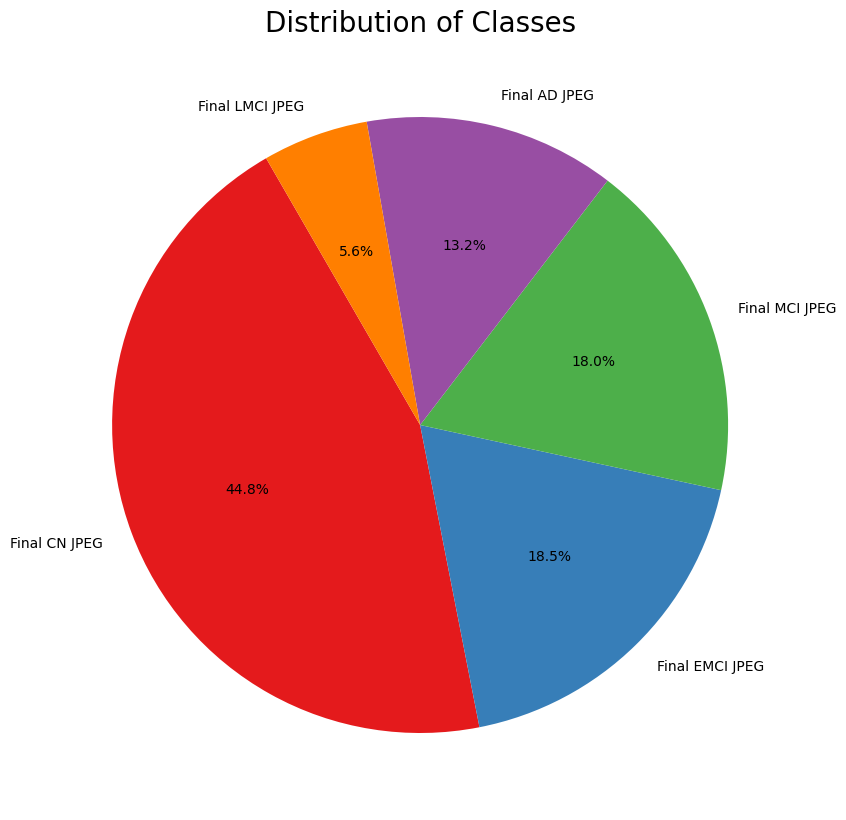

In [ ]:
plt.figure(figsize=(10, 10))
labels = df['label'].value_counts().index
sizes = df['label'].value_counts().values
colors = sns.color_palette('Set1')

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=120)
plt.title('Distribution of Classes', fontsize=20)
plt.show()

****Plotting the Actual No. of Images in Class Distribution of the Dataset befor Applying Data Augmentation Methods****

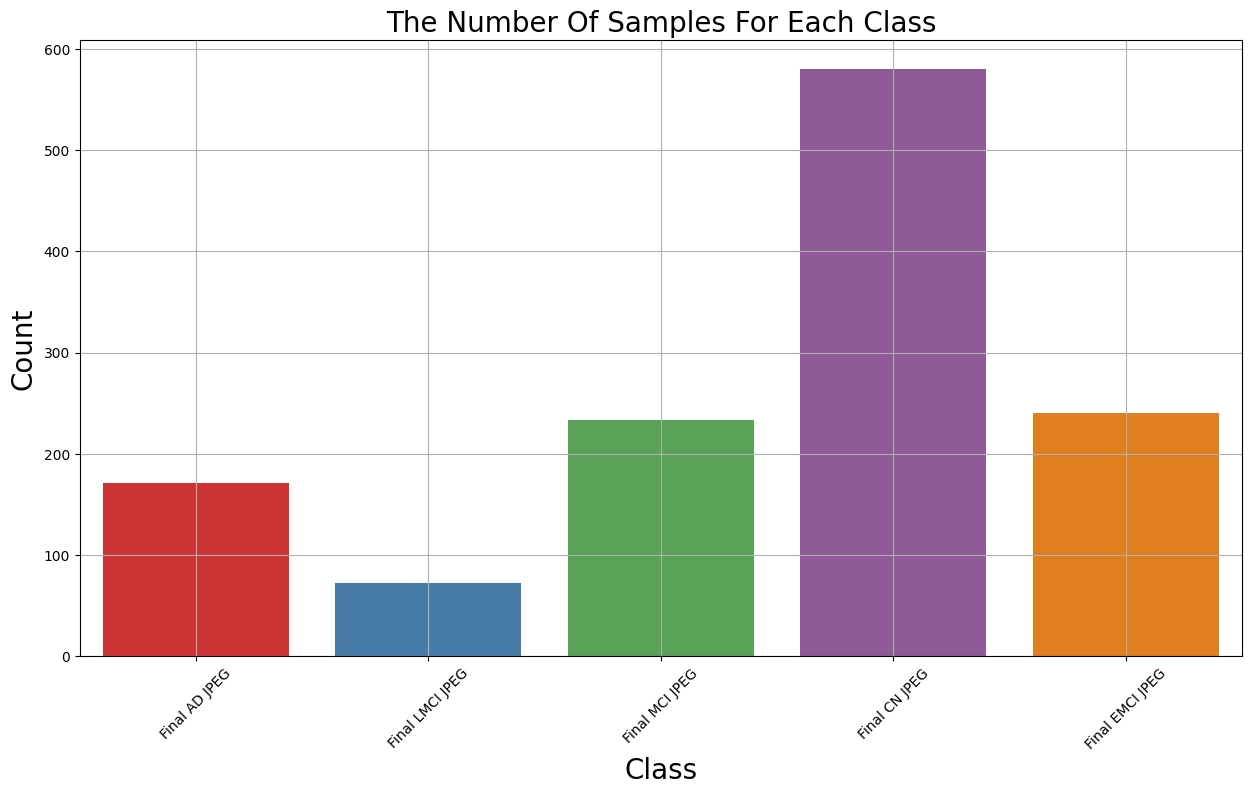

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x=df.label,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
,plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

****Plotting the Sample Images from the Dataset****

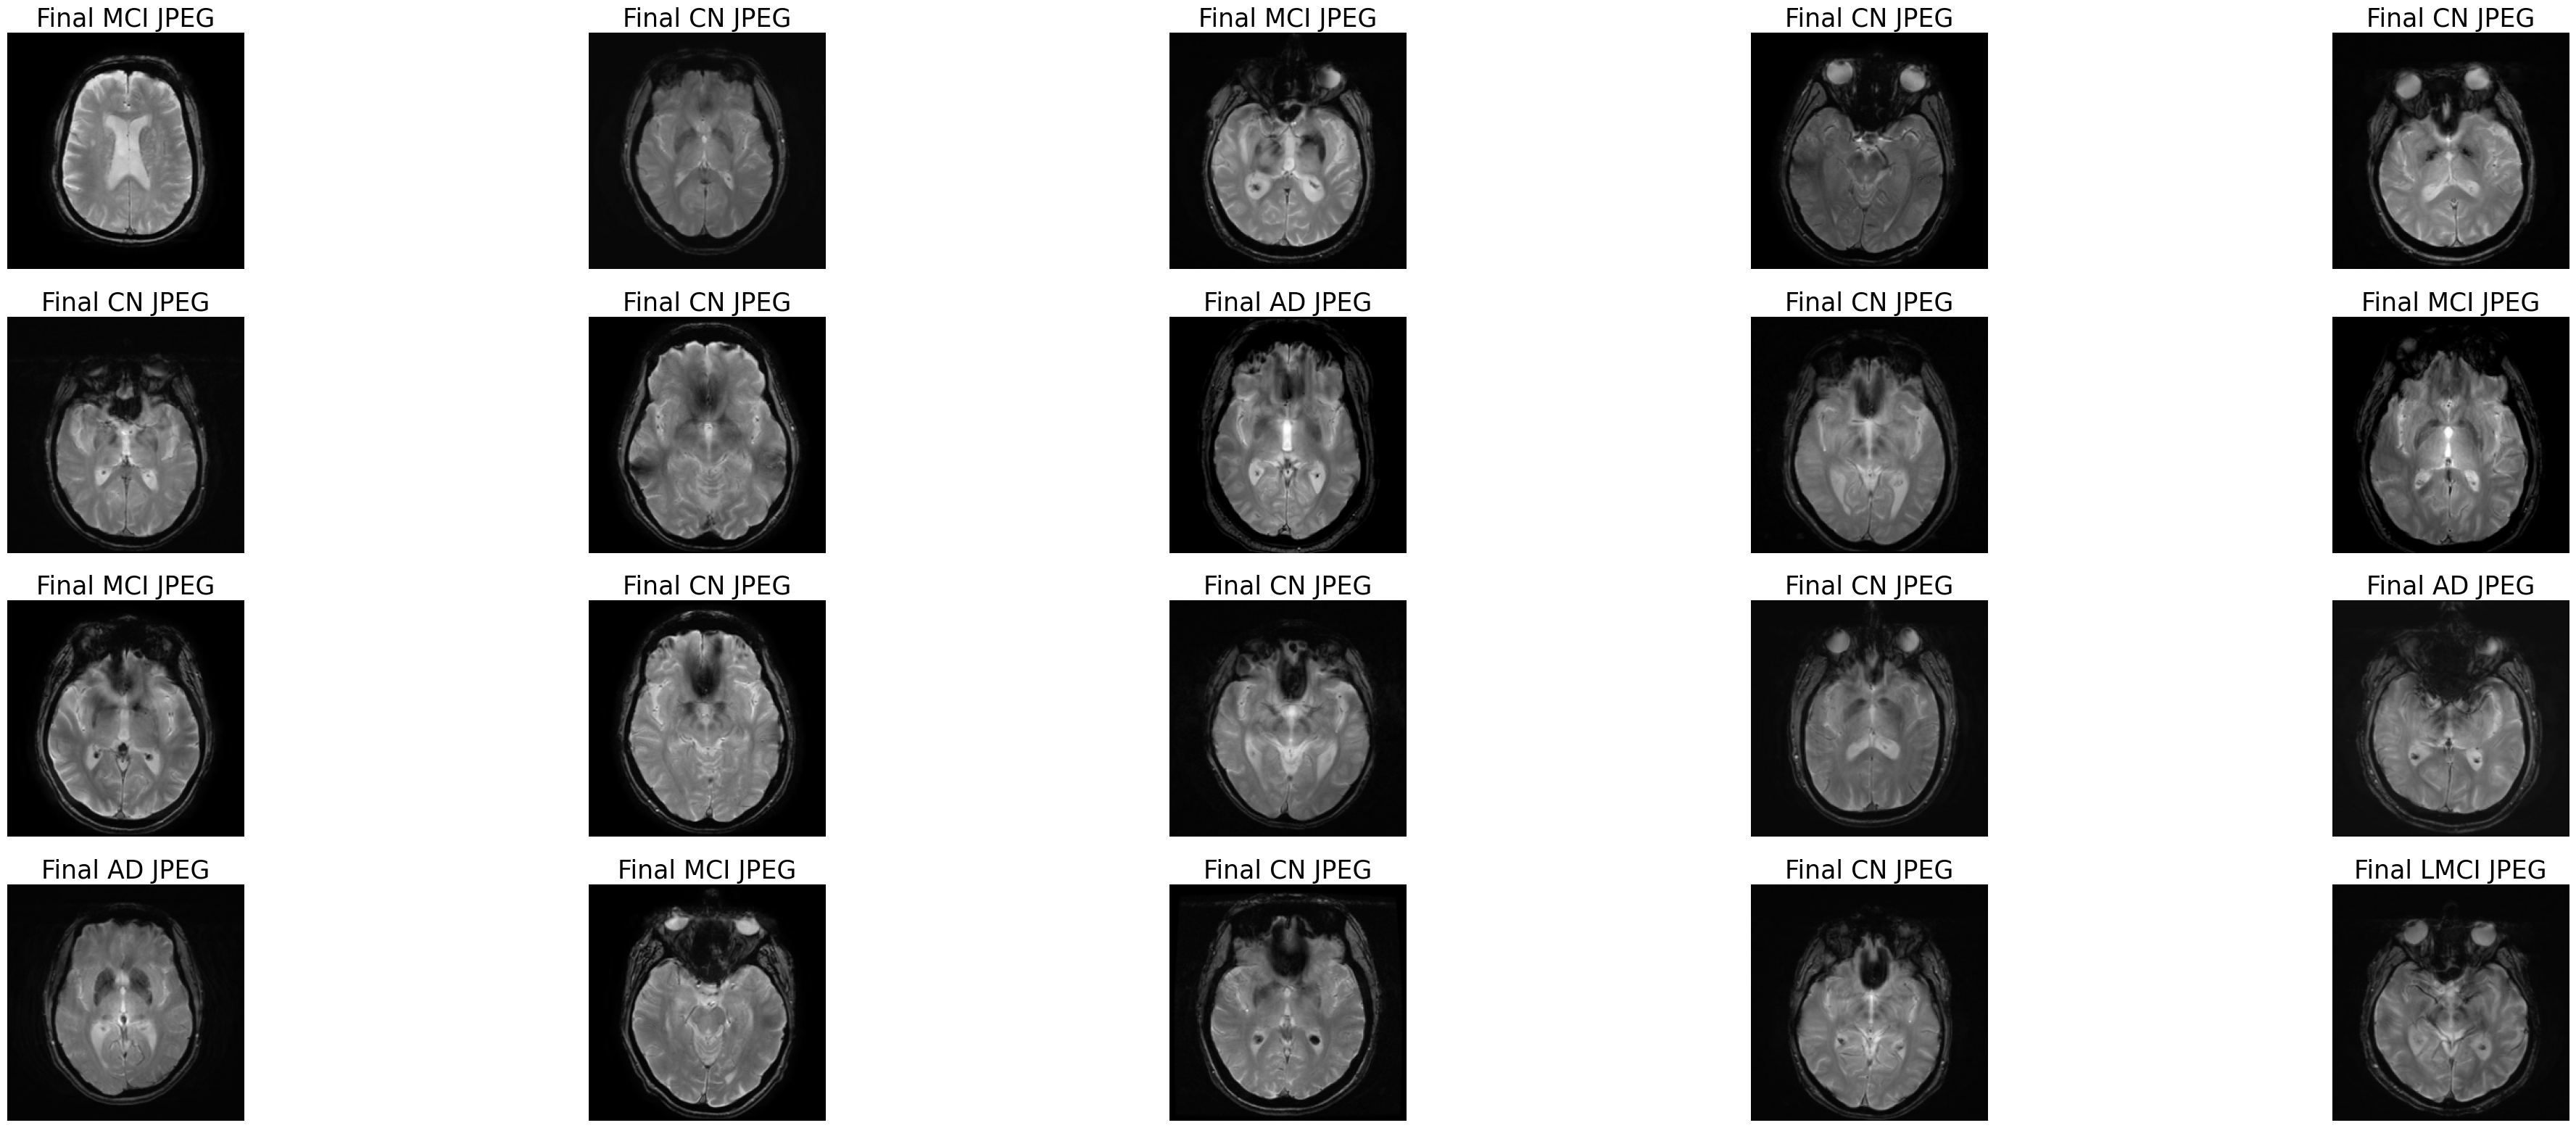

In [ ]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),20)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

In [ ]:
Size=(176,176)
work_dr = ImageDataGenerator(
    rescale = 1./255
)
train_data_gen = work_dr.flow_from_dataframe(df,x_col='image',y_col='label', target_size=Size, batch_size=6500, shuffle=False)

Found 1296 validated image filenames belonging to 5 classes.


**Before and After Resizing and Normalization**

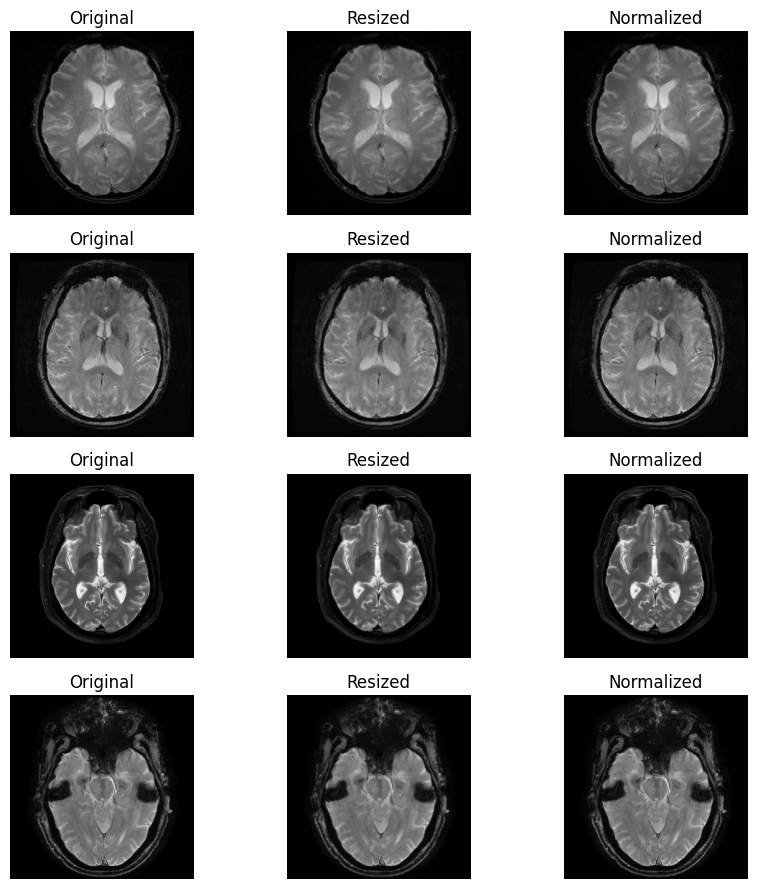

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Function to normalize the images
def normalize_image(image):
    return image / 255.0

# Function to resize images to 224x224
def resize_image(image, size=(224, 224)):
    return cv2.resize(image, size)

# Function to load images from a given path
def load_images(input_path, num_images=4):
    image_files = [os.path.join(input_path, img) for img in os.listdir(input_path) if img.endswith(('jpg', 'jpeg', 'png'))]
    selected_images = random.sample(image_files, num_images)
    return [cv2.imread(img) for img in selected_images], selected_images

# Function to display images in a three-column layout
def display_three_columns(original_images, resized_images, normalized_images):
    fig, axes = plt.subplots(len(original_images), 3, figsize=(9, 9))
    for i in range(len(original_images)):
        # Original image
        axes[i, 0].imshow(cv2.cvtColor(original_images[i], cv2.COLOR_BGR2RGB))
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')

        # Resized image
        axes[i, 1].imshow(cv2.cvtColor(resized_images[i], cv2.COLOR_BGR2RGB))
        axes[i, 1].set_title('Resized')
        axes[i, 1].axis('off')

        # Normalized image
        axes[i, 2].imshow(cv2.cvtColor(normalized_images[i], cv2.COLOR_BGR2RGB))
        axes[i, 2].set_title('Normalized')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Main function to process and display images
def main(input_path):
    # Load 4 random images
    original_images, _ = load_images(input_path)

    # Resize images
    resized_images = [resize_image(img) for img in original_images]

    # Normalize images (convert to 8-bit for visualization)
    normalized_images = [(normalize_image(img) * 255).astype(np.uint8) for img in original_images]

    # Display the images in three columns
    display_three_columns(original_images, resized_images, normalized_images)

# Specify the input path
input_path = '/kaggle/input/alzheimersdisease5classdatasetadni/Alzheimers-ADNI/test/Final AD JPEG'
main(input_path)


****MINORITY CLASS UMPSAMPLING TO OVERCOME THE CLASS IMBALANCE AND DMALLER DATASET PROBLEMS****

**Synthetic Minority Over-sampling Technique (SMOTE)** is a popular technique used to handle class imbalance problems in machine learning, where one class has a significantly larger number of instances than the others. In Python, you can implement SMOTE using the imbalanced-learn library.

**What is SMOTE?**

SMOTE is a method that generates new minority class samples by interpolating between existing minority class samples. The idea is to create synthetic samples that are similar to the existing minority class samples, but not identical. This helps to increase the size of the minority class, making it more balanced with the majority class.

**How Does SMOTE Work?**

**Here's a Step-by-Step Explanation of the SMOTE Algorithm:**

**Identify the Minority Class:** Determine which class has the smallest number of instances.

**Select a Minority Class Sample:** Randomly select a sample from the minority class.

**Find k-Nearest Neighbors:** Find the k-nearest neighbors of the selected minority class sample.

**Generate a Synthetic Sample:** Create a new synthetic sample by interpolating between the selected minority class sample and one of its k-nearest neighbors.

In [ ]:
for x, y in train_data_gen:
    train_data, train_labels = x, y
    break
train_data, train_labels = next(iter(train_data_gen))

In [ ]:
class_num=np.sort(['Final AD JPEG','Final CN JPEG', 'Final EMCI JPEG', 'Final LMCI JPEG', 'Final MCI JPEG'])
class_num

array(['Final AD JPEG', 'Final CN JPEG', 'Final EMCI JPEG',
       'Final LMCI JPEG', 'Final MCI JPEG'], dtype='<U15')

In [ ]:
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 176 * 176 * 3), train_labels)
train_data = train_data.reshape(-1, 176,176, 3)
print(train_data.shape, train_labels.shape)

(2900, 176, 176, 3) (2900, 5)


****Plotting the Sample Size of Each CLass After Data Augmentation/ Minority Upsampling through SMOTE Algorithm****

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


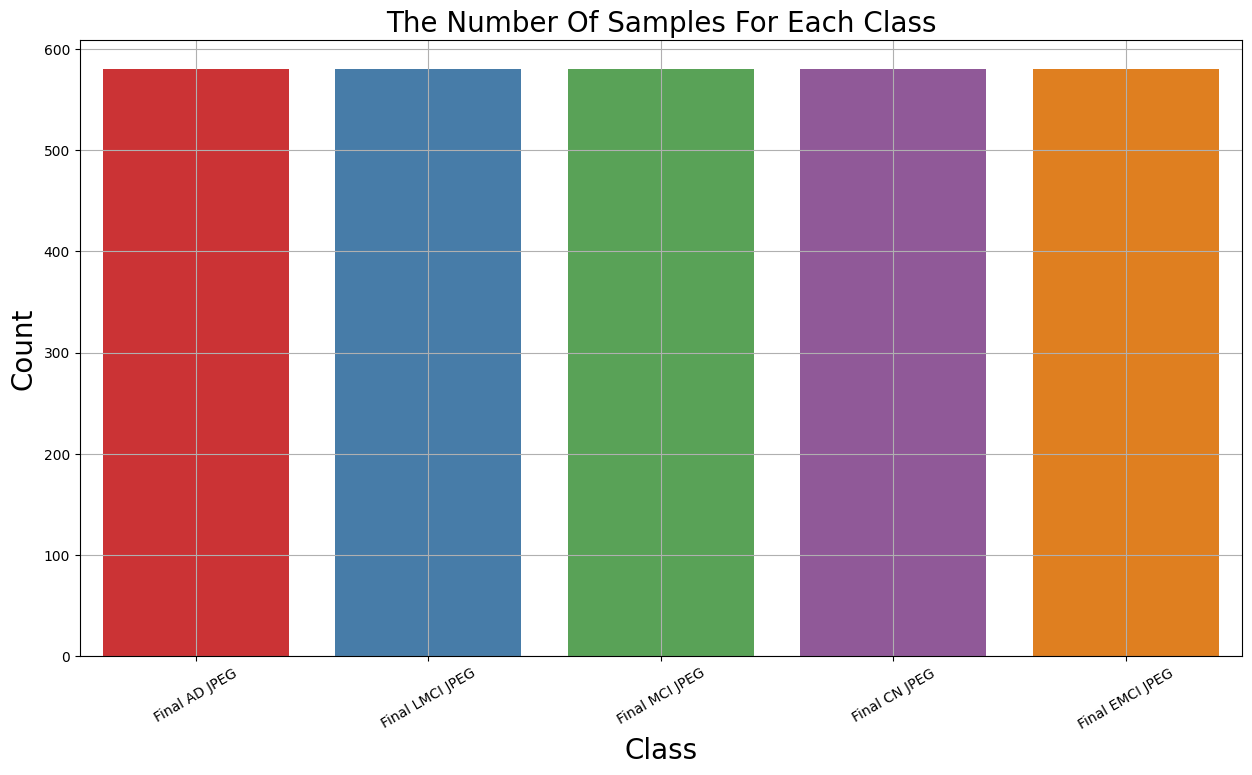

In [ ]:
labels=[class_num[i] for i in np.argmax(train_labels,axis=1) ]
plt.figure(figsize=(15,8))
ax = sns.countplot(x=labels,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.xticks(rotation=30)
plt.show()

****Class-wise Distribution of the Dataset after Data Augmentation****

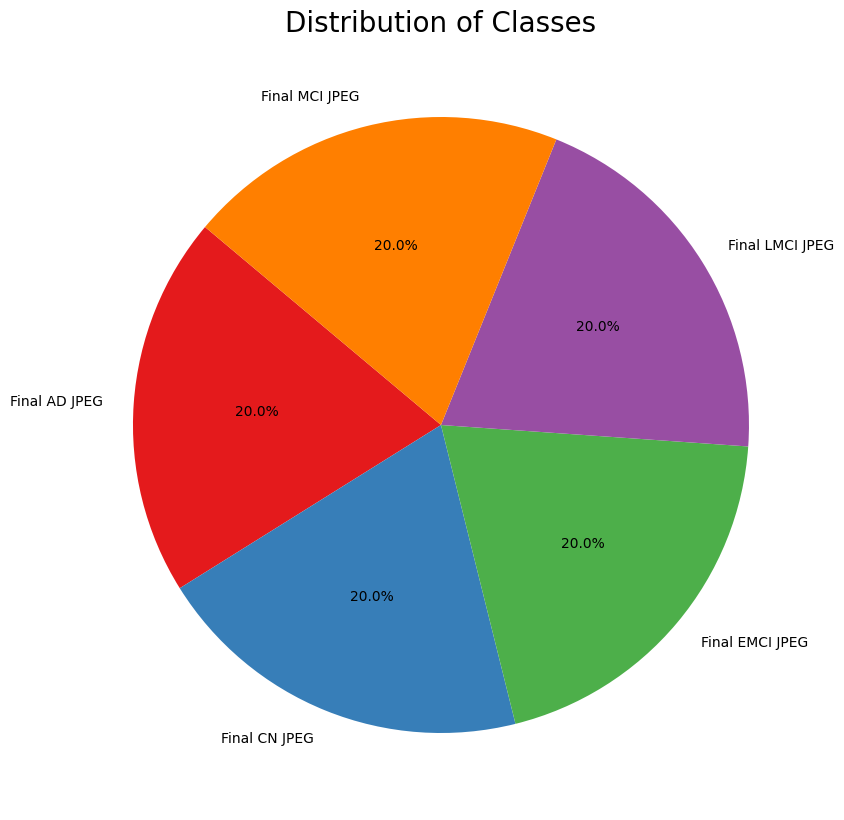

In [ ]:
labels = [class_num[i] for i in np.argmax(train_labels, axis=1)]

plt.figure(figsize=(10, 10))
unique_labels = np.unique(labels)
sizes = [labels.count(label) for label in unique_labels]
colors = sns.color_palette('Set1')

plt.pie(sizes, labels=unique_labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes', fontsize=20)
plt.show()


**Data Splitting**

The code is splitting a dataset into training, validation, and testing sets using the train_test_split function from Scikit-learn.

**1.First Split**

The first train_test_split call is splitting the train_data and train_labels into two sets:

X_train and y_train: The training set, which will be used to train the model.

X_test1 and y_test1: The testing set, which will be used to evaluate the model's performance.

The parameters used in this split are:

test_size=0.3: The proportion of the data to include in the testing set (30%).

random_state=42: The random seed used to ensure reproducibility.

shuffle=True: The data will be shuffled before splitting.

stratify=train_labels: The split will be stratified based on the train_labels, which means that the proportion of each class in the training and testing sets will be preserved.

**2.Second Split**

The second train_test_split call is splitting the X_test1 and y_test1 sets into two sets:

X_val and y_val: The validation set, which will be used to tune hyperparameters and evaluate the model's performance during training.

X_test and y_test: The final testing set, which will be used to evaluate the model's performance after training.

The parameters used in this split are:

test_size=0.5: The proportion of the data to include in the validation set (50%).

random_state=42: The random seed used to ensure reproducibility.

shuffle=True: The data will be shuffled before splitting.

stratify=y_test1: The split will be stratified based on the y_test1 labels, which means that the proportion of each class in the validation and testing sets will be preserved.

**Printing the Shape of Training, Validation and Testing Sets**

The code then prints the shapes of the resulting datasets:

X_train.shape: The shape of the training data.

X_test.shape: The shape of the final testing data.

X_val.shape: The shape of the validation data.

y_train.shape: The shape of the training labels.

y_test.shape: The shape of the final testing labels.

y_val.shape: The shape of the validation labels.

The output will show the number of samples and features in each dataset.

In [ ]:
X_train, X_test1, y_train, y_test1 = train_test_split(train_data,train_labels, test_size=0.3, random_state=42,shuffle=True,stratify=train_labels)
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('X_val shape is ' , X_val.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)
print('y_val shape is ' , y_val.shape)

X_train shape is  (2030, 176, 176, 3)
X_test shape is  (435, 176, 176, 3)
X_val shape is  (435, 176, 176, 3)
y_train shape is  (2030, 5)
y_test shape is  (435, 5)
y_val shape is  (435, 5)


**MODEL_1: LINEAR CNN USING PRETRAINED EfficientNetB2**


**Model Definition**

The CNN model, denoted as model1, is defined using the **Keras Sequential API**. This API allows for the creation of a linear stack of layers, where each layer is added sequentially to the model.

**Layer 1: EfficientNetB2**

The first layer added to the model is an EfficientNetB2 layer, which is a pre-trained convolutional neural network (CNN) architecture. The EfficientNetB2 model is a variant of the EfficientNet family, which is designed to achieve state-of-the-art performance on image classification tasks while being computationally efficient.

The EfficientNetB2 layer is initialized with the following parameters:

weights='imagenet': The layer is initialized with pre-trained weights from the ImageNet dataset, which is a large-scale image classification dataset.

include_top=False: The top layer of the pre-trained model is not included, allowing the model to be fine-tuned for the specific task at hand.

input_shape=(176, 176, 3): The input shape of the layer is set to (176, 176, 3), which corresponds to the height, width, and number of color channels (RGB) of the input images.

**Layer 2: Flatten**

The second layer added to the model is a Flatten layer, which is used to flatten the output of the EfficientNetB2 layer into a one-dimensional feature vector. This is necessary because the output of the EfficientNetB2 layer is a 3D tensor, and the subsequent layers require a 1D input.

**Layer 3: Dense (256, ReLU)**

The third layer added to the model is a dense (fully connected) layer with 256 neurons, using the ReLU (Rectified Linear Unit) activation function. This layer is used to learn a non-linear representation of the input data.

**Layer 4: Dropout (0.5)**

The fourth layer added to the model is a Dropout layer with a dropout rate of 0.5. This layer randomly sets 50% of the neurons to zero during training, which helps to prevent overfitting by reducing the capacity of the model.

**Layer 5: Dense (5, Softmax)**

The final layer added to the model is a dense layer with 5 neurons, using the softmax activation function. This layer is used to output a probability distribution over the 5 classes.

**Model Compilation**

The model is compiled with the following parameters:

loss='categorical_crossentropy': The loss function used to train the model is categorical cross-entropy, which is suitable for multi-class classification problems.

optimizer=optimizers.RMSprop(learning_rate=1e-4): The optimizer used to update the model parameters is RMSprop, with a learning rate of 1e-4.

metrics=['accuracy']: The model is evaluated using the accuracy metric, which measures the proportion of correctly classified samples.

In [ ]:
!pip install EfficientNet
model1 = Sequential()
model1.add(EfficientNetB2(weights='imagenet', include_top=False, input_shape=(176, 176, 3)))
model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(5, activation='softmax'))

model1.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

model1.summary()

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.1 MB/s eta 0:00:00
31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb2 (Functional)     │ ?                      │     7,768,569 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,768,569 (29.63 MB)

 Trainable params: 7,700,994 (29.38 MB)

 Non-trainable params: 67,575 (263.97 KB)

****Training the Linear CNN Model for 100 Epochs****

In [ ]:
model1_history = model1.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/100


I0000 00:00:1720616120.432277     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


280/280 ━━━━━━━━━━━━━━━━━━━━ 152s 163ms/step - accuracy: 0.6121 - loss: 1.0591 - val_accuracy: 0.2500 - val_loss: 2.4467
Epoch 2/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 36s 130ms/step - accuracy: 0.8575 - loss: 0.3564 - val_accuracy: 0.2500 - val_loss: 1.6420
Epoch 3/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 36s 129ms/step - accuracy: 0.9276 - loss: 0.2002 - val_accuracy: 0.5427 - val_loss: 1.1372
Epoch 4/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 36s 129ms/step - accuracy: 0.9569 - loss: 0.1279 - val_accuracy: 0.9458 - val_loss: 0.2371
Epoch 5/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 36s 129ms/step - accuracy: 0.9694 - loss: 0.0988 - val_accuracy: 0.9609 - val_loss: 0.1553
Epoch 6/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 36s 129ms/step - accuracy: 0.9792 - loss: 0.0642 - val_accuracy: 0.9812 - val_loss: 0.1021
Epoch 7/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 41s 129ms/step - accuracy: 0.9831 - loss: 0.0512 - val_accuracy: 0.9828 - val_loss: 0.0575
Epoch 8/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 36s 129ms/step - accuracy: 0.9852 - loss: 0.04

**Model Evaluation**

The presented code snippet evaluates the performance of a machine learning model on a test dataset using the evaluate method. The evaluate method is a built-in function in Keras, a popular deep learning library, that computes the loss and metrics of a model on a given dataset.

**Input Parameters**

The evaluate method takes three input parameters:

X_test: The test dataset, which is a set of input samples used to evaluate the model's performance.
y_test: The corresponding labels for the test dataset, which are used to compute the model's accuracy and other metrics.
verbose=0: A parameter that controls the verbosity of the output. In this case, verbose=0 means that the evaluation process will be silent, and only the final results will be returned.

**Output Metrics**

The evaluate method returns a tuple of five values, which are assigned to the following variables:

test_loss: The average loss of the model on the test dataset, which measures the difference between the model's predictions and the true labels.
test_acc: The accuracy of the model on the test dataset, which is the proportion of correctly classified samples.
test_precision: The precision of the model on the test dataset, which is the ratio of true positives to the sum of true positives and false positives.
test_recall: The recall of the model on the test dataset, which is the ratio of true positives to the sum of true positives and false negatives.
test_f1_score: The F1 score of the model on the test dataset, which is the harmonic mean of precision and recall.

In [ ]:
test_loss, test_acc = model1.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy', test_acc)
print('Test Loss', test_loss)

Test Accuracy 0.9979166388511658
Test Loss 0.024022428318858147


**Visualization Functions for Model Evaluation**

The presented code defines two functions for visualizing the performance of machine learning models: plot_confusion_matrix and plot_training_history. These functions are essential for evaluating the effectiveness of a model and identifying areas for improvement.

**1.Confusion Matrix Visualization**

The plot_confusion_matrix function generates a confusion matrix, a fundamental tool in machine learning for evaluating the performance of a classification model. The function takes three inputs:

model_name: A string indicating the name of the model being evaluated.
y_true: A vector of true labels for the test data.
y_pred: A vector of predicted labels generated by the model.
The function first computes the confusion matrix using the confusion_matrix function from Scikit-learn. The confusion matrix is a square matrix that summarizes the predictions against the true labels, providing insights into the accuracy of the model.

The function then uses the heatmap function from Seaborn to visualize the confusion matrix. The heatmap is a 2D representation of the matrix, where the color intensity corresponds to the frequency of each prediction. The x-axis and y-axis represent the predicted and true labels, respectively. The annot=True parameter adds numerical annotations to each cell, and the fmt='g' parameter specifies the format of the annotations.

The title of the plot is set to "Confusion Matrix - {model_name} Model", where {model_name} is replaced with the actual model name. The x-axis and y-axis labels are set to "Predicted" and "True", respectively.

**2.Training History Visualization**

The plot_training_history function visualizes the training history of a model, providing insights into the model's convergence and performance over time. The function takes two inputs:

model_name: A string indicating the name of the model being evaluated.
history: A dictionary containing the training history of the model, including the accuracy and loss values at each epoch.
The function uses the subplots function from Matplotlib to create a figure with two subplots. The first subplot displays the accuracy of the model over time, with the training accuracy and validation accuracy plotted separately. The second subplot displays the loss of the model over time, with the training loss and validation loss plotted separately.

The plot function is used to create the plots, and the legend function is used to add a legend to each plot. The title of each subplot is set to "{model_name} Model Accuracy" and "{model_name} Model Loss", respectively. The x-axis and y-axis labels are set to "Epochs" and "Accuracy" or "Loss", respectively.

The show function is used to display the plots.

These visualization functions provide a comprehensive understanding of a model's performance, enabling researchers and practitioners to identify areas for improvement and optimize their models for better results.

In [ ]:
# Plot confusion matrices
def plot_confusion_matrix(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_num, yticklabels=class_num)
    plt.title(f'Confusion Matrix - {model_name} Model')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def plot_training_history(model_name, history):
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))

    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title(f'{model_name} Model Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title(f'{model_name} Model Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.show()


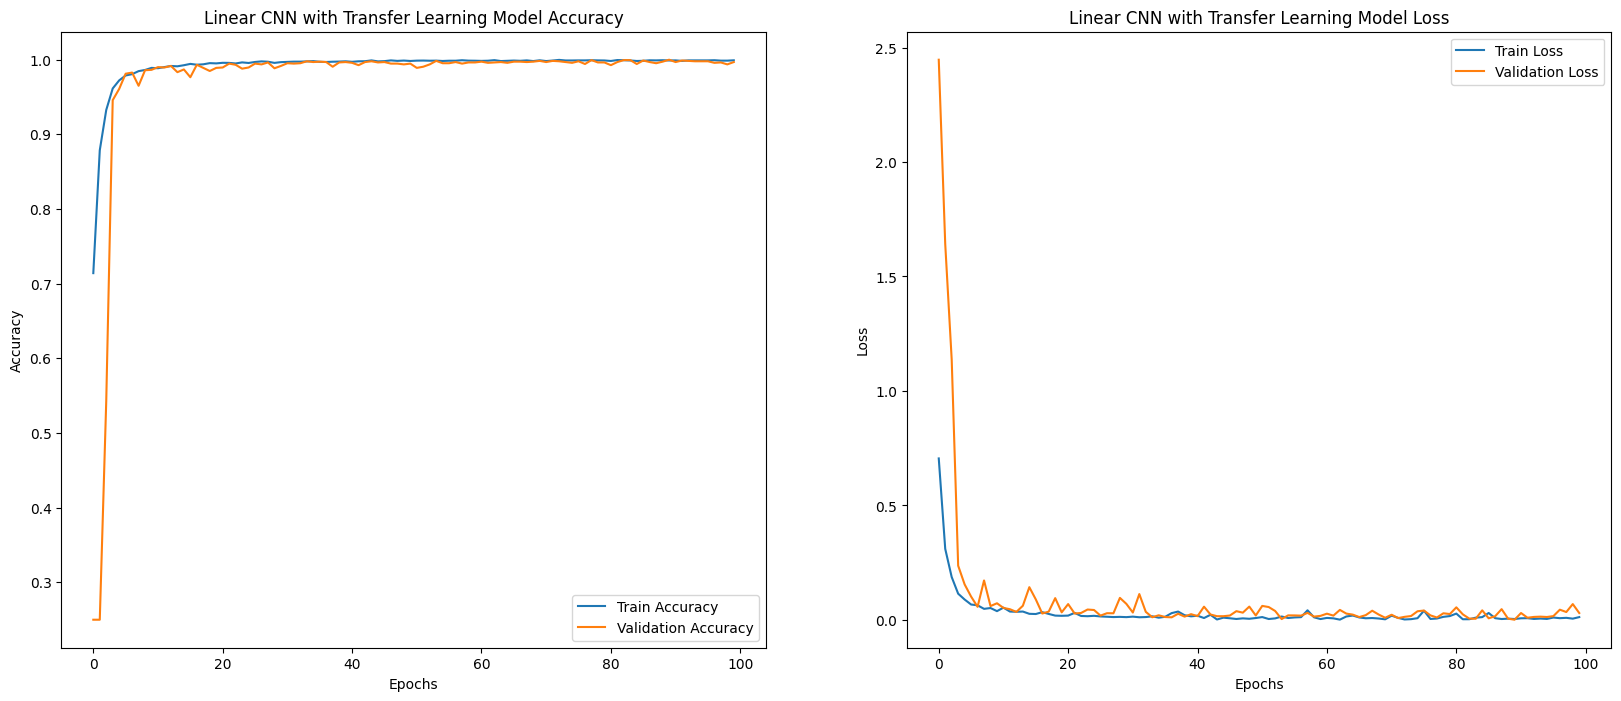

In [ ]:
plot_training_history('Linear CNN with Transfer Learning', model1_history)

**Define the confusion matrix**

In [ ]:
y_pred_model1 = model1.predict(X_test).argmax(axis=1)
plot_confusion_matrix('Linear CNN', np.argmax(y_test, axis=1), y_pred_model1)


**GET ALL THE RESULTS**

Class-wise Metrics:
--------------------
Accuracy: [0.93650794 0.92134831 0.91549296 0.93902439 0.88311688]
F1 Score: [0.93280632 0.92655367 0.90909091 0.92215569 0.90666667]
Specificity: [0.97178683 0.98314607 0.98128342 0.97796143 0.98641304]
Sensitivity: [0.92913386 0.93181818 0.90277778 0.90588235 0.93150685]
Loss: [0.06349206 0.07865169 0.08450704 0.06097561 0.11688312]

Overall Metrics:
------------------
Accuracy: 0.9213483146067416
F1 Score: 0.9195632564469187
Specificity: 0.9803370786516854
Sensitivity: 0.9213483146067416
Loss: 0.0786516853932584


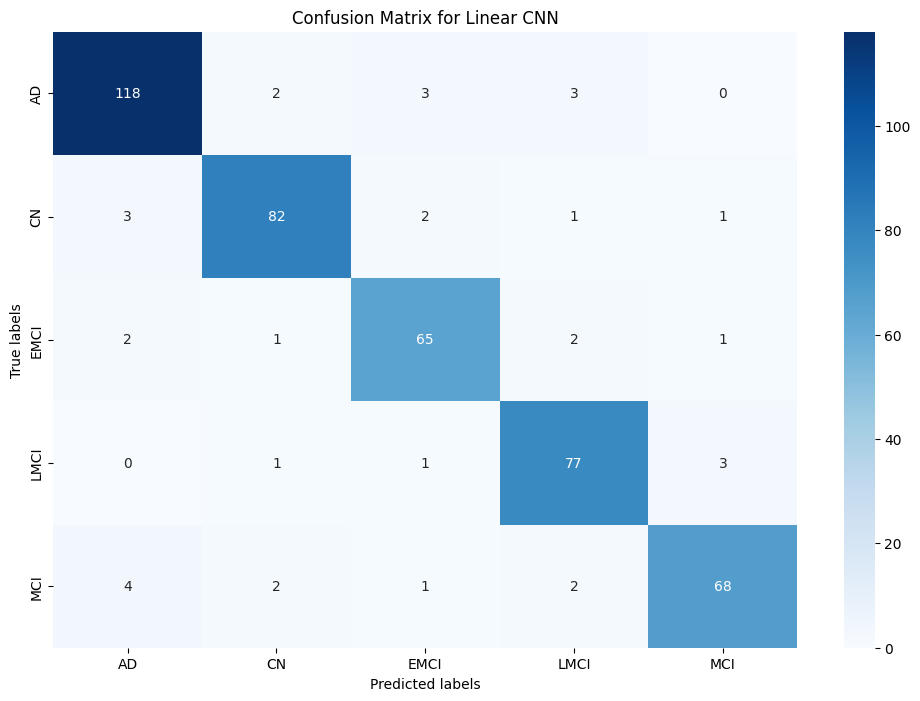

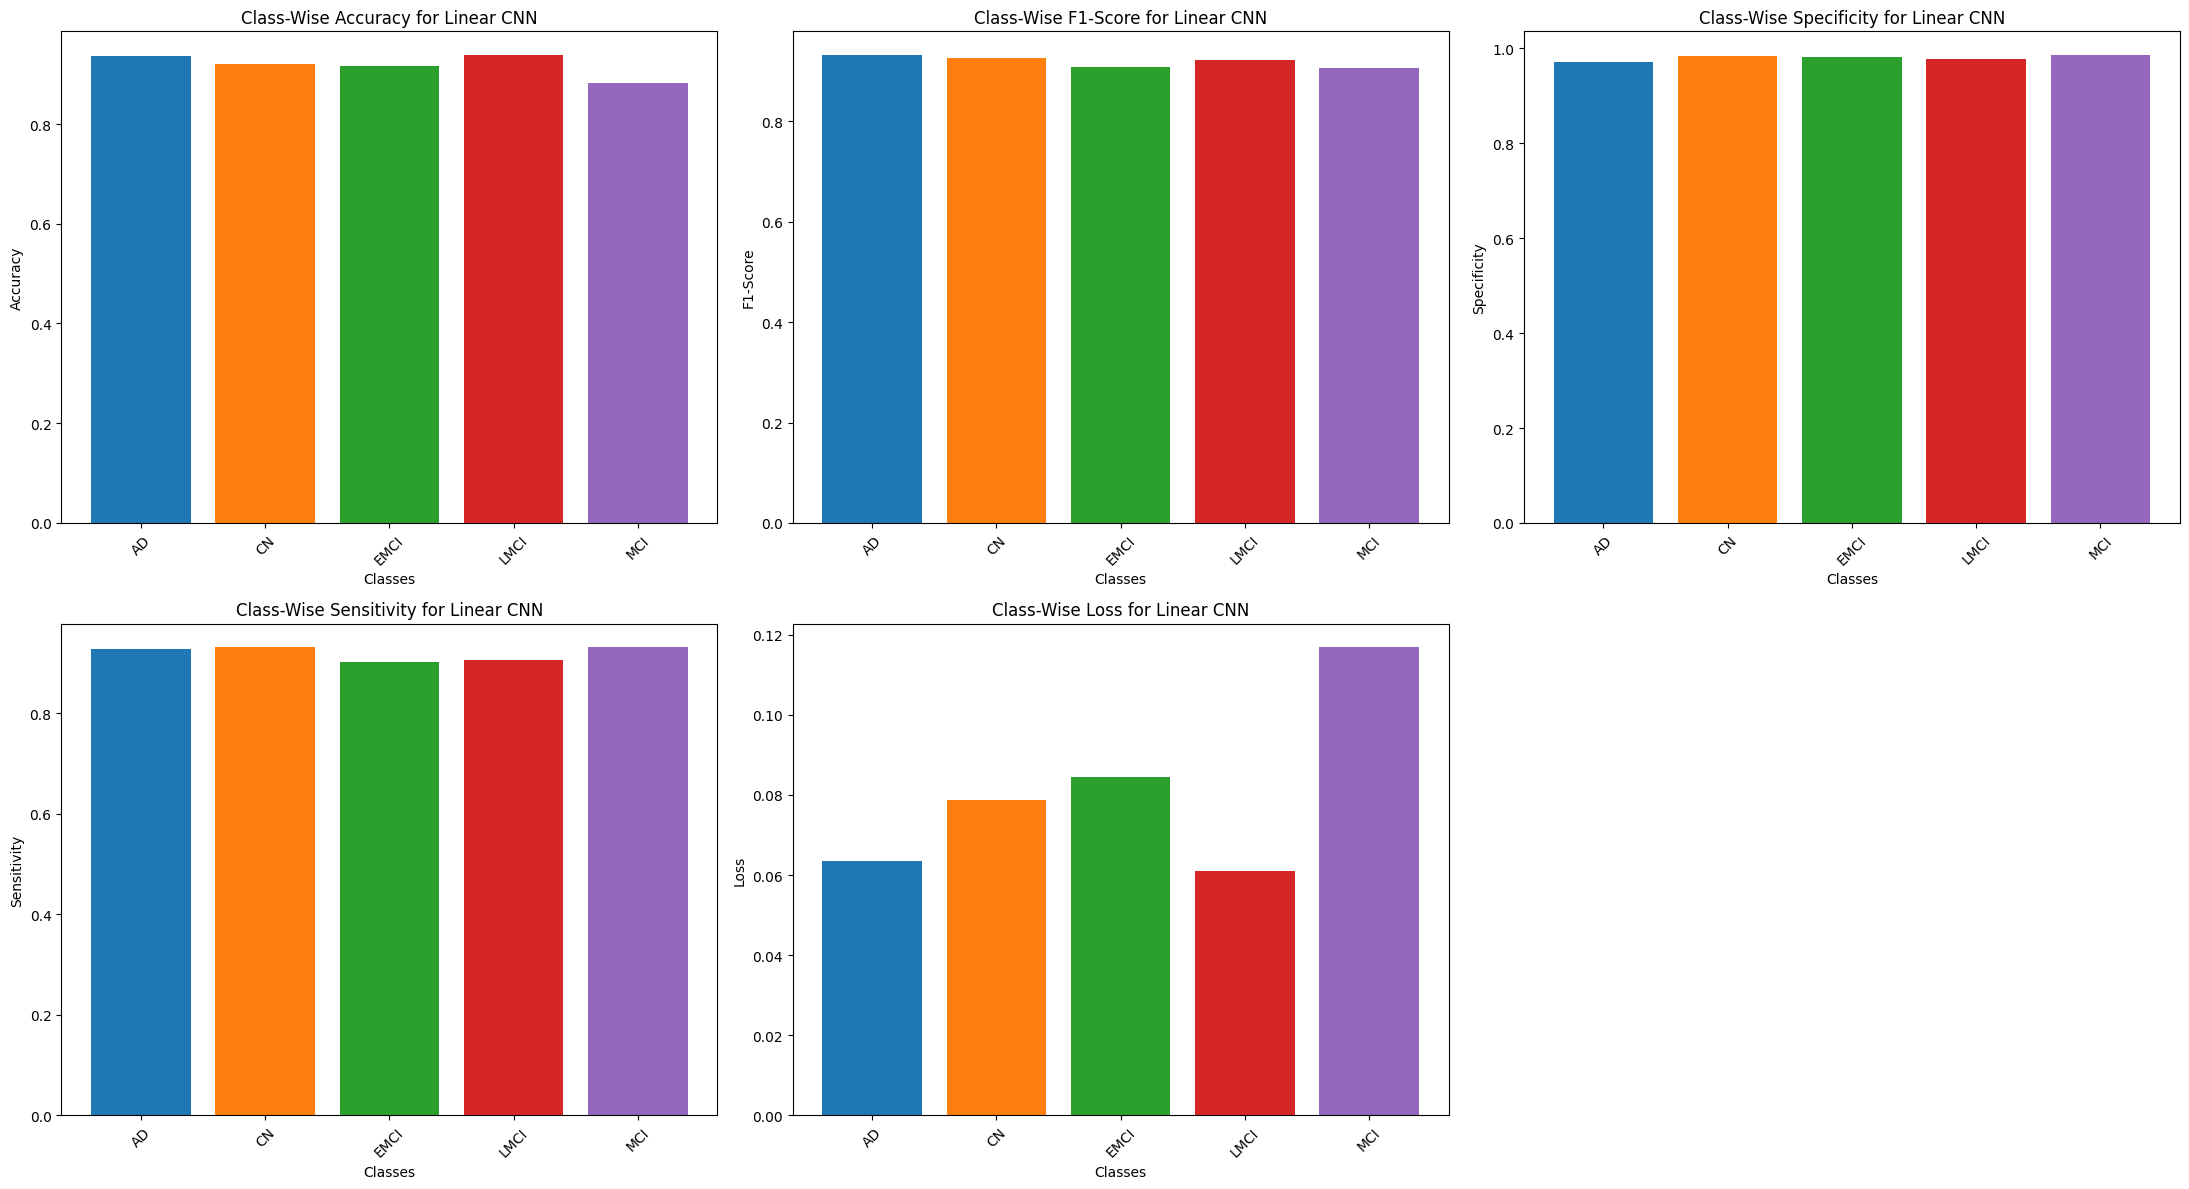

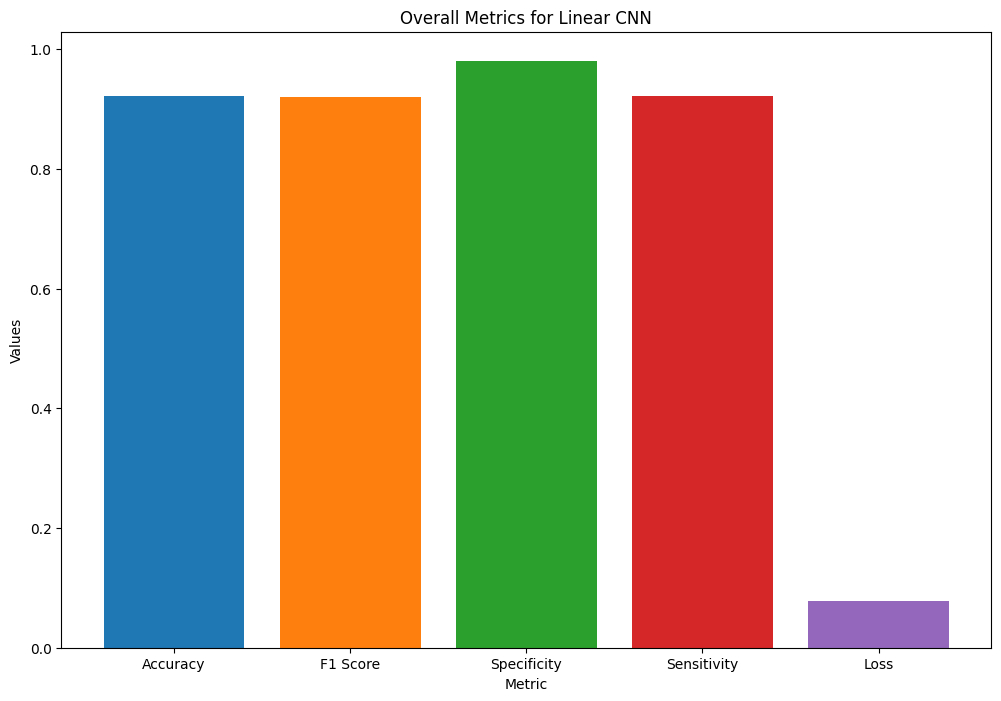

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Define the confusion matrix
cm = np.array([[118,2,3,3,0],
              [3,82,2,1,1],
              [2,1,65,2,1],
              [0,1,1,77,3],
              [4,2,1,2,68]])

# Define the class names
class_names = ['AD', 'CN', 'EMCI', 'LMCI', 'MCI']

# Calculate class-wise metrics
class_accuracy = np.diag(cm) / np.sum(cm, axis=1)

# Calculate class-wise F1 score
class_f1_score = []
for i in range(5):
    tp = cm[i, i]
    fp = np.sum(cm[:, i]) - tp
    fn = np.sum(cm[i, :]) - tp
    tn = np.sum(cm) - tp - fp - fn
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    class_f1_score.append(f1)

class_f1_score = np.array(class_f1_score)

class_specificity = np.array([np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1)) / np.sum(np.delete(cm, i, axis=0)) for i in range(5)])
class_sensitivity = np.diag(cm) / np.sum(cm, axis=0)
class_loss = 1 - class_accuracy


# Calculate overall metrics
overall_accuracy = np.sum(np.diag(cm)) / np.sum(cm)
# Assuming that the true labels and predicted labels are not available
# We can calculate the overall F1 score using the precision and recall
# calculated from the confusion matrix
precision = np.diag(cm) / np.sum(cm, axis=0)
recall = np.diag(cm) / np.sum(cm, axis=1)
overall_f1_score = 2 * np.mean(precision * recall) / (np.mean(precision) + np.mean(recall))
overall_specificity = np.sum([np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1)) for i in range(5)]) / np.sum([np.sum(np.delete(cm, i, axis=0)) for i in range(5)])
overall_sensitivity = np.sum(np.diag(cm)) / np.sum(cm)
overall_loss = 1 - overall_accuracy
# Print the scores
print("Class-wise Metrics:")
print("--------------------")
print("Accuracy:", class_accuracy)
print("F1 Score:", class_f1_score)
print("Specificity:", class_specificity)
print("Sensitivity:", class_sensitivity)
print("Loss:", class_loss)

print("\nOverall Metrics:")
print("------------------")
print("Accuracy:", overall_accuracy)
print("F1 Score:", overall_f1_score)
print("Specificity:", overall_specificity)
print("Sensitivity:", overall_sensitivity)
print("Loss:", overall_loss)

plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names, fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Linear CNN')
plt.show()

class_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Create a figure with 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(22, 12))

# Plot class-wise accuracy
axs[0, 0].bar(range(5), class_accuracy, color=[class_colors[i] for i in range(5)])
axs[0, 0].set_xticks(range(5))
axs[0, 0].set_xticklabels(class_names, rotation=45)
axs[0, 0].set_xlabel('Classes')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].set_title('Class-Wise Accuracy for Linear CNN')

# Plot class-wise F1 score
axs[0, 1].bar(range(5), class_f1_score, color=[class_colors[i] for i in range(5)])
axs[0, 1].set_xticks(range(5))
axs[0, 1].set_xticklabels(class_names, rotation=45)
axs[0, 1].set_xlabel('Classes')
axs[0, 1].set_ylabel('F1-Score')
axs[0, 1].set_title('Class-Wise F1-Score for Linear CNN')

# Plot class-wise specificity
axs[0, 2].bar(range(5), class_specificity, color=[class_colors[i] for i in range(5)])
axs[0, 2].set_xticks(range(5))
axs[0, 2].set_xticklabels(class_names, rotation=45)
axs[0, 2].set_xlabel('Classes')
axs[0, 2].set_ylabel('Specificity')
axs[0, 2].set_title('Class-Wise Specificity for Linear CNN')

# Plot class-wise sensitivity
axs[1, 0].bar(range(5), class_sensitivity, color=[class_colors[i] for i in range(5)])
axs[1, 0].set_xticks(range(5))
axs[1, 0].set_xticklabels(class_names, rotation=45)
axs[1, 0].set_xlabel('Classes')
axs[1, 0].set_ylabel('Sensitivity')
axs[1, 0].set_title('Class-Wise Sensitivity for Linear CNN')

# Plot class-wise loss
axs[1, 1].bar(range(5), class_loss, color=[class_colors[i] for i in range(5)])
axs[1, 1].set_xticks(range(5))
axs[1, 1].set_xticklabels(class_names, rotation=45)
axs[1, 1].set_xlabel('Classes')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].set_title('Class-Wise Loss for Linear CNN')

# Remove the empty subplot
fig.delaxes(axs[1, 2])

plt.tight_layout()
plt.show()

# Define the colors for each metric
metric_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Plot overall metrics
plt.figure(figsize=(12,8))
plt.bar(['Accuracy', 'F1 Score', 'Specificity', 'Sensitivity', 'Loss'],
        [overall_accuracy, overall_f1_score, overall_specificity, overall_sensitivity, overall_loss],
        color=metric_colors)
plt.xlabel('Metric')
plt.ylabel('Values')
plt.title('Overall Metrics for Linear CNN')
plt.show()

****DUAL BRANCH MODEL WITH Linear CONCATENATION****

The model consists of two identical branches, each comprising a series of convolutional and pooling layers, followed by a concatenation layer and additional dense layers.

**Input Shape and Branch Architecture**

The input shape of the model is defined as (176, 176, 3), indicating that the model is designed to process color images with a spatial resolution of 176x176 pixels. Each branch of the model consists of five convolutional blocks, each comprising a convolutional layer with a kernel size of 3x3, followed by a max-pooling layer with a pool size of 2x2. The number of filters in each convolutional layer increases progressively from 32 to 512, allowing the model to capture features at multiple scales.

**Concatenation and Dense Layers**

The output of each branch is flattened and concatenated using a concatenation layer, resulting in a feature vector with a length of 1024. The concatenated feature vector is then fed into a series of dense layers, comprising five layers with 512, 256, 128, 64, and 4 neurons, respectively. The dense layers are designed to learn complex patterns and relationships between the features extracted by the convolutional layers.

**Activation Functions and Regularization**

The model employs the ReLU (Rectified Linear Unit) activation function in the convolutional and dense layers, which introduces non-linearity and enhances the model's ability to learn complex patterns. Additionally, dropout regularization is applied to the dense layers with a dropout rate of 0.2, which helps to prevent overfitting by randomly dropping out neurons during training.

**Output Layer and Loss Function**

The output layer of the model consists of four neurons with a softmax activation function, which outputs a probability distribution over four classes. The model is trained using the categorical cross-entropy loss function, which measures the difference between the predicted probabilities and the true labels.

**Optimizer and Metrics**

The model is optimized using the Adam optimizer, a popular stochastic gradient descent algorithm that adapts the learning rate during training. The model's performance is evaluated using the accuracy metric, which measures the proportion of correctly classified samples.

**Model Summary**

The model summary reveals that the model consists of 14,634,544 trainable parameters, indicating a relatively complex architecture. The model's depth and width are designed to capture complex patterns and relationships in the input data, making it suitable for image classification tasks.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the input shape
input_shape = (176, 176, 3)

# Define the two branches
branch1 = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten()
])

branch2 = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten()
])

# Define the input layer
input_layer = layers.Input(shape=input_shape)

# Define the output of each branch
x1 = branch1(input_layer)
x2 = branch2(input_layer)

# Concatenate the output of each branch
x_concat = layers.Concatenate()([x1, x2])

# Add additional layers
x = layers.Dense(512, activation='relu')(x_concat)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(5, activation='softmax')(x)

# Define the model
model3 = tf.keras.Model(inputs=input_layer, outputs=x)

# Compile the model
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model3.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 176, 176,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 4608)      │  1,568,576 │ input_layer_22[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 4608)      │  1,568,576 │ input_layer_22[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 9216)      │          0 │ sequential_3[0][… │
│ (Concatenate)       │                   │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 512)       │  4,719,104 │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 512)       │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │    131,328 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 128)       │     32,896 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128)       │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │      8,256 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64)        │          0 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 4)         │        260 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,028,996 (30.63 MB)

 Trainable params: 8,028,996 (30.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model3_history = model3.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 25s 47ms/step - accuracy: 0.2528 - loss: 1.3968 - val_accuracy: 0.2500 - val_loss: 1.3863
Epoch 2/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.2484 - loss: 1.3843 - val_accuracy: 0.4161 - val_loss: 1.3315
Epoch 3/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.5061 - loss: 1.0159 - val_accuracy: 0.6443 - val_loss: 0.7093
Epoch 4/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.6603 - loss: 0.7131 - val_accuracy: 0.6880 - val_loss: 0.6486
Epoch 5/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.6764 - loss: 0.6810 - val_accuracy: 0.6948 - val_loss: 0.6348
Epoch 6/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.6938 - loss: 0.6317 - val_accuracy: 0.7156 - val_loss: 0.6035
Epoch 7/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.7340 - loss: 0.5844 - val_accuracy: 0.7589 - val_loss: 0.5269
Epoch 8/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.7621 - loss: 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9930 - loss: 0.0269 - val_accuracy: 0.9578 - val_loss: 0.1487
Epoch 85/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9848 - loss: 0.0463 - val_accuracy: 0.9807 - val_loss: 0.0677
Epoch 86/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9854 - loss: 0.0568 - val_accuracy: 0.9786 - val_loss: 0.0784
Epoch 87/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9910 - loss: 0.0306 - val_accuracy: 0.9380 - val_loss: 0.1861
Epoch 88/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.7663 - loss: 0.6744 - val_accuracy: 0.6016 - val_loss: 0.8162
Epoch 89/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.6505 - loss: 0.7939 - val_accuracy: 0.8427 - val_loss: 0.3702
Epoch 90/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.8636 - loss: 0.3373 - val_accuracy: 0.9312 - val_loss: 0.1789
Epoch 91/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9444 - loss: 0.1481

In [ ]:
test_loss, test_acc = model3.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy', test_acc)
print('Test Loss', test_loss)

Test Accuracy 0.979687511920929
Test Loss 0.0751180574297905


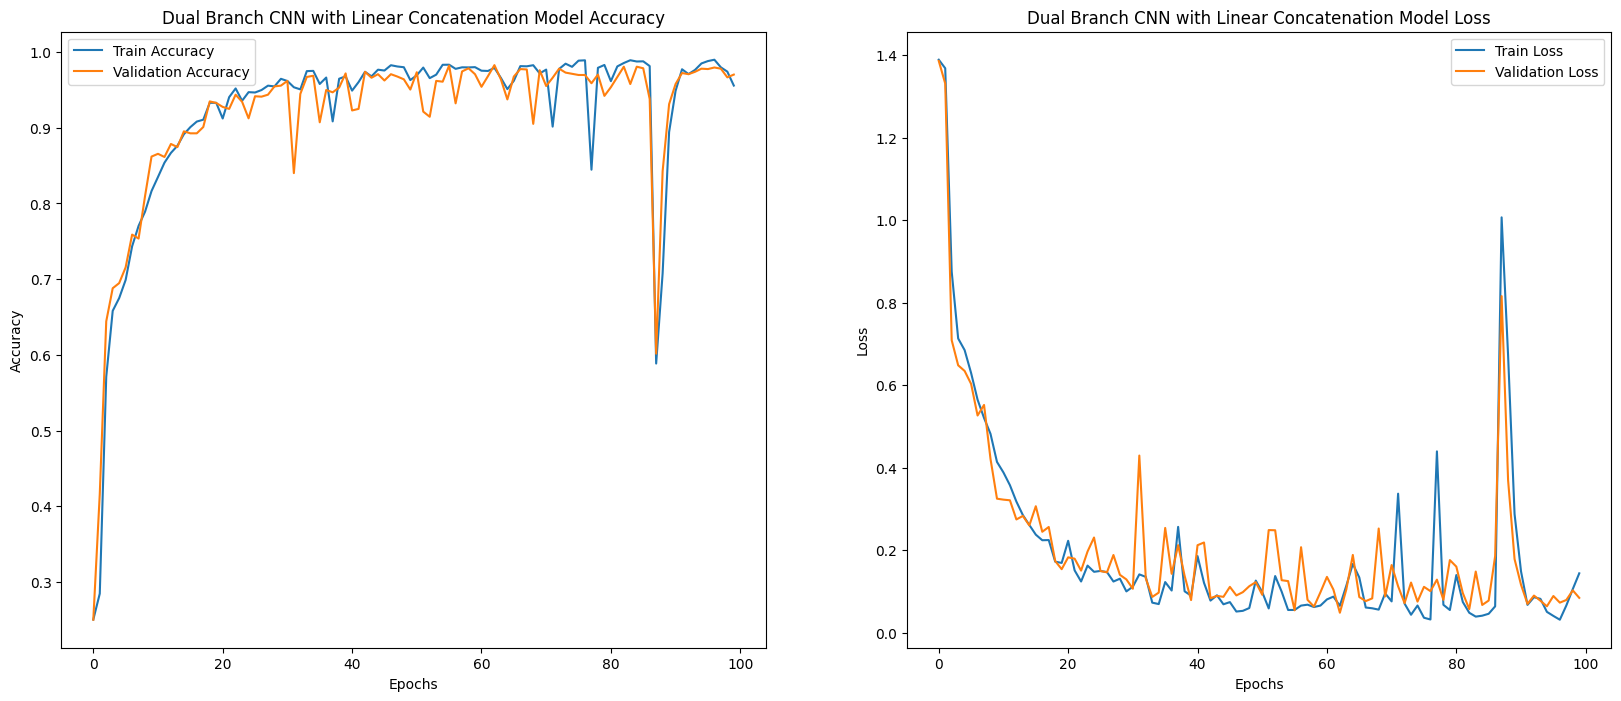

In [ ]:
plot_training_history('Dual Branch CNN with Linear Concatenation', model3_history)

**Define the confusion matrix**

In [ ]:
y_pred_model3 = model3.predict(X_test).argmax(axis=1)
plot_confusion_matrix('DB-CNN with Linear Concatenation', np.argmax(y_test, axis=1), y_pred_model3)

**Now Get all the Results**

Class-wise Metrics:
--------------------
Accuracy: [0.95238095 0.95505618 0.90140845 0.95121951 0.90909091]
F1 Score: [0.94488189 0.94444444 0.92086331 0.93413174 0.93333333]
Specificity: [0.97492163 0.98314607 0.98930481 0.98071625 0.99184783]
Sensitivity: [0.9375     0.93406593 0.94117647 0.91764706 0.95890411]
Loss: [0.04761905 0.04494382 0.09859155 0.04878049 0.09090909]

Overall Metrics:
------------------
Accuracy: 0.9370786516853933
F1 Score: 0.9356126289839946
Specificity: 0.9842696629213483
Sensitivity: 0.9370786516853933
Loss: 0.06292134831460672


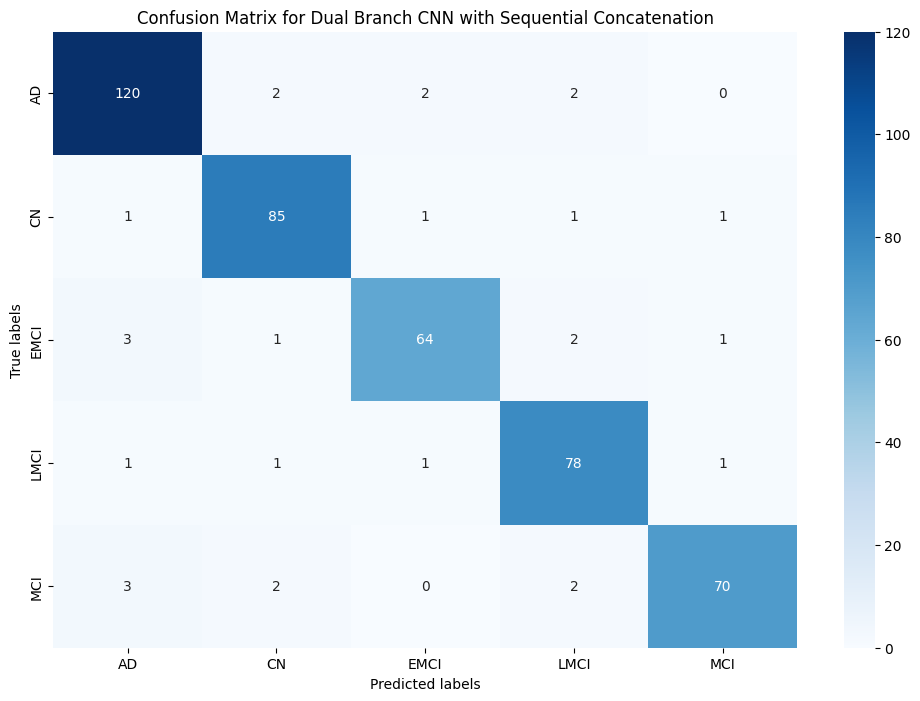

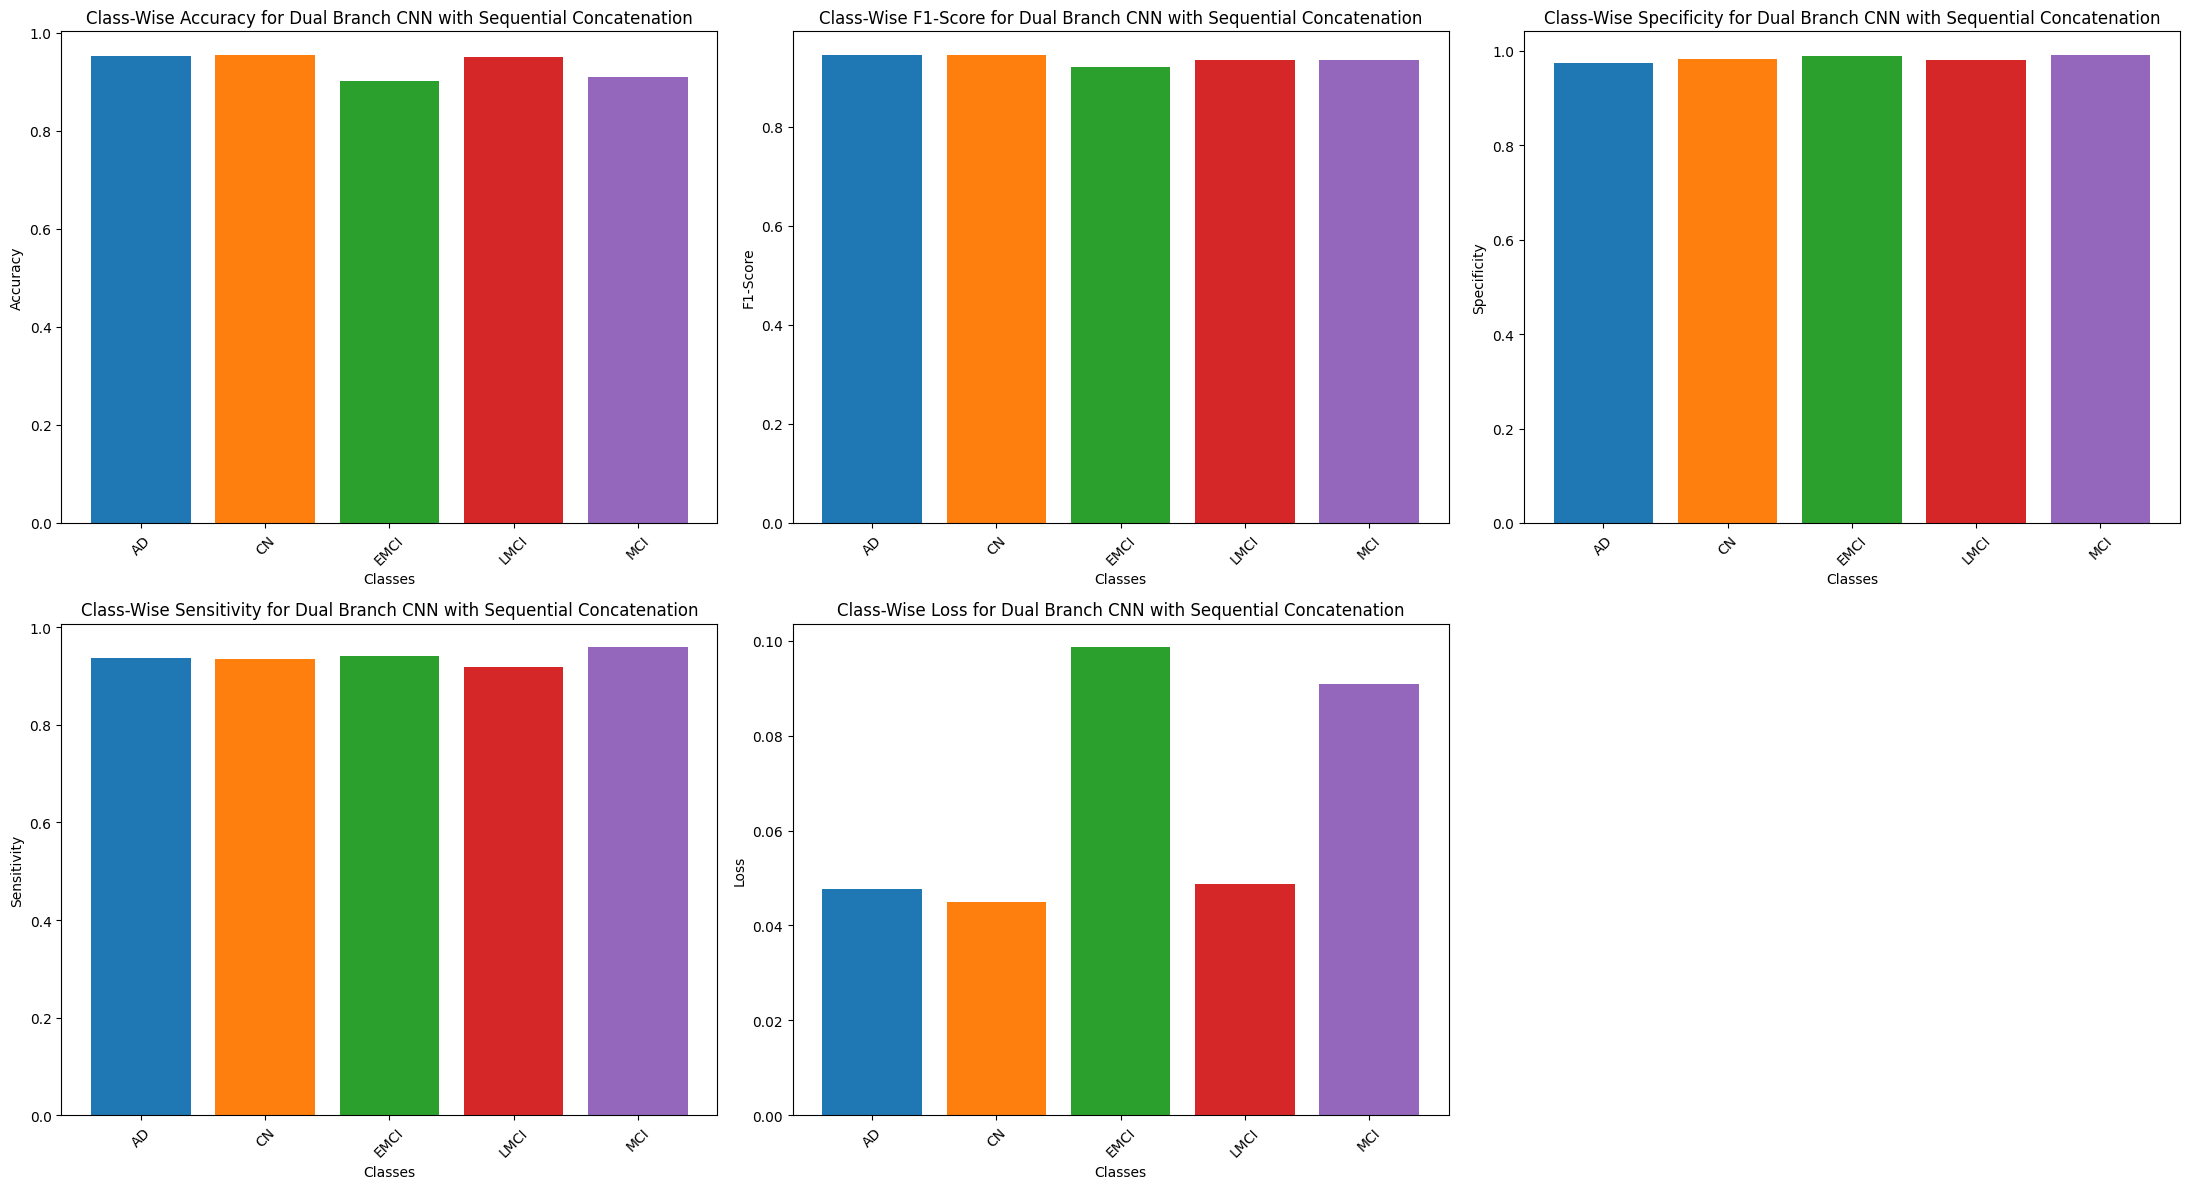

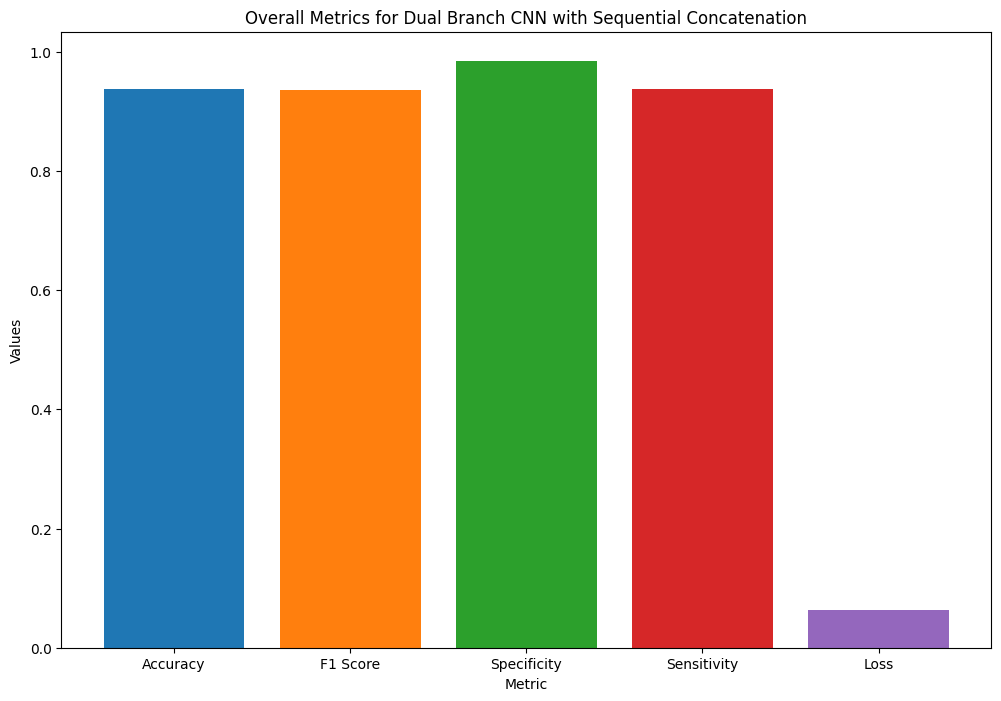

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Define the confusion matrix
cm = np.array([[120,2,2,2,0],
              [1,85,1,1,1],
              [3,1,64,2,1],
              [1,1,1,78,1],
              [3,2,0,2,70]])

# Calculate class-wise metrics
class_accuracy = np.diag(cm) / np.sum(cm, axis=1)

# Calculate class-wise F1 score
class_f1_score = []
for i in range(5):
    tp = cm[i, i]
    fp = np.sum(cm[:, i]) - tp
    fn = np.sum(cm[i, :]) - tp
    tn = np.sum(cm) - tp - fp - fn
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    class_f1_score.append(f1)

class_f1_score = np.array(class_f1_score)

class_specificity = np.array([np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1)) / np.sum(np.delete(cm, i, axis=0)) for i in range(5)])
class_sensitivity = np.diag(cm) / np.sum(cm, axis=0)
class_loss = 1 - class_accuracy


# Calculate overall metrics
overall_accuracy = np.sum(np.diag(cm)) / np.sum(cm)
# Assuming that the true labels and predicted labels are not available
# We can calculate the overall F1 score using the precision and recall
# calculated from the confusion matrix
precision = np.diag(cm) / np.sum(cm, axis=0)
recall = np.diag(cm) / np.sum(cm, axis=1)
overall_f1_score = 2 * np.mean(precision * recall) / (np.mean(precision) + np.mean(recall))
overall_specificity = np.sum([np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1)) for i in range(5)]) / np.sum([np.sum(np.delete(cm, i, axis=0)) for i in range(5)])
overall_sensitivity = np.sum(np.diag(cm)) / np.sum(cm)
overall_loss = 1 - overall_accuracy
# Print the scores
print("Class-wise Metrics:")
print("--------------------")
print("Accuracy:", class_accuracy)
print("F1 Score:", class_f1_score)
print("Specificity:", class_specificity)
print("Sensitivity:", class_sensitivity)
print("Loss:", class_loss)

print("\nOverall Metrics:")
print("------------------")
print("Accuracy:", overall_accuracy)
print("F1 Score:", overall_f1_score)
print("Specificity:", overall_specificity)
print("Sensitivity:", overall_sensitivity)
print("Loss:", overall_loss)

plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names, fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Dual Branch CNN with Sequential Concatenation')
plt.show()

class_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Create a figure with 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(22, 12))

# Plot class-wise accuracy
axs[0, 0].bar(range(5), class_accuracy, color=[class_colors[i] for i in range(5)])
axs[0, 0].set_xticks(range(5))
axs[0, 0].set_xticklabels(class_names, rotation=45)
axs[0, 0].set_xlabel('Classes')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].set_title('Class-Wise Accuracy for Dual Branch CNN with Sequential Concatenation')

# Plot class-wise F1 score
axs[0, 1].bar(range(5), class_f1_score, color=[class_colors[i] for i in range(5)])
axs[0, 1].set_xticks(range(5))
axs[0, 1].set_xticklabels(class_names, rotation=45)
axs[0, 1].set_xlabel('Classes')
axs[0, 1].set_ylabel('F1-Score')
axs[0, 1].set_title('Class-Wise F1-Score for Dual Branch CNN with Sequential Concatenation')

# Plot class-wise specificity
axs[0, 2].bar(range(5), class_specificity, color=[class_colors[i] for i in range(5)])
axs[0, 2].set_xticks(range(5))
axs[0, 2].set_xticklabels(class_names, rotation=45)
axs[0, 2].set_xlabel('Classes')
axs[0, 2].set_ylabel('Specificity')
axs[0, 2].set_title('Class-Wise Specificity for Dual Branch CNN with Sequential Concatenation')

# Plot class-wise sensitivity
axs[1, 0].bar(range(5), class_sensitivity, color=[class_colors[i] for i in range(5)])
axs[1, 0].set_xticks(range(5))
axs[1, 0].set_xticklabels(class_names, rotation=45)
axs[1, 0].set_xlabel('Classes')
axs[1, 0].set_ylabel('Sensitivity')
axs[1, 0].set_title('Class-Wise Sensitivity for Dual Branch CNN with Sequential Concatenation')

# Plot class-wise loss
axs[1, 1].bar(range(5), class_loss, color=[class_colors[i] for i in range(5)])
axs[1, 1].set_xticks(range(5))
axs[1, 1].set_xticklabels(class_names, rotation=45)
axs[1, 1].set_xlabel('Classes')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].set_title('Class-Wise Loss for Dual Branch CNN with Sequential Concatenation')

# Remove the empty subplot
fig.delaxes(axs[1, 2])

plt.tight_layout()
plt.show()
# Define the colors for each metric
metric_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Plot overall metrics
plt.figure(figsize=(12,8))
plt.bar(['Accuracy', 'F1 Score', 'Specificity', 'Sensitivity', 'Loss'],
        [overall_accuracy, overall_f1_score, overall_specificity, overall_sensitivity, overall_loss],
        color=metric_colors)
plt.xlabel('Metric')
plt.ylabel('Values')
plt.title('Overall Metrics for Dual Branch CNN with Sequential Concatenation')
plt.show()

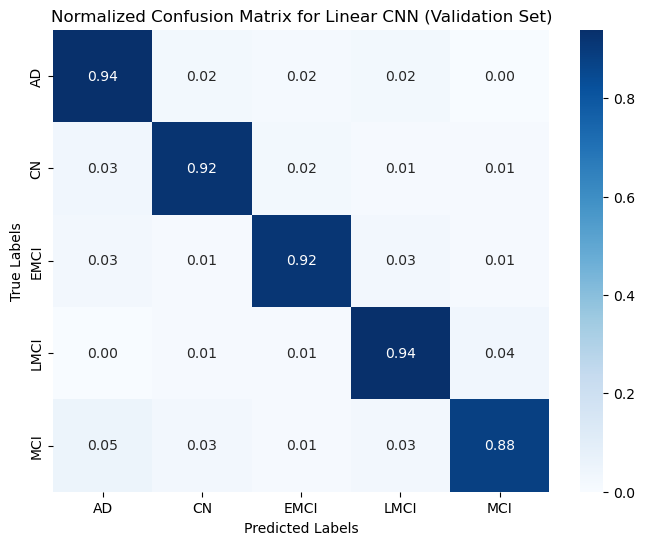

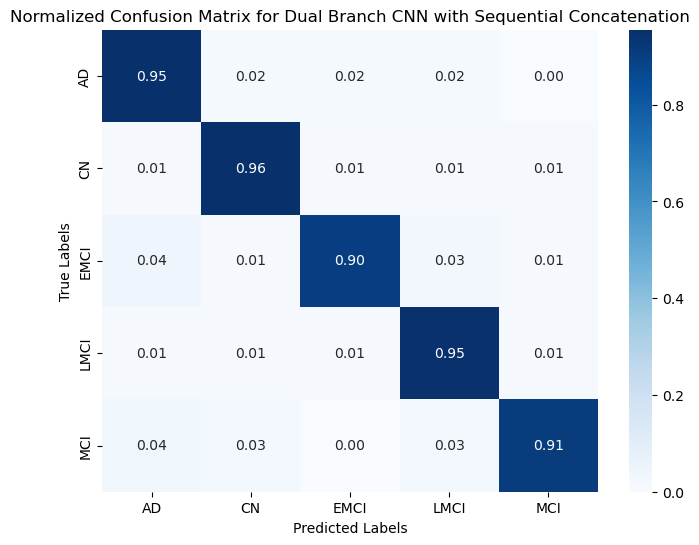

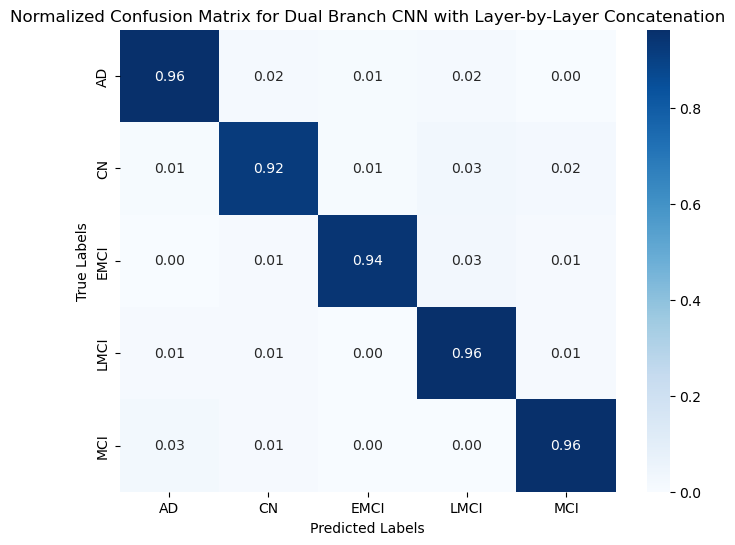

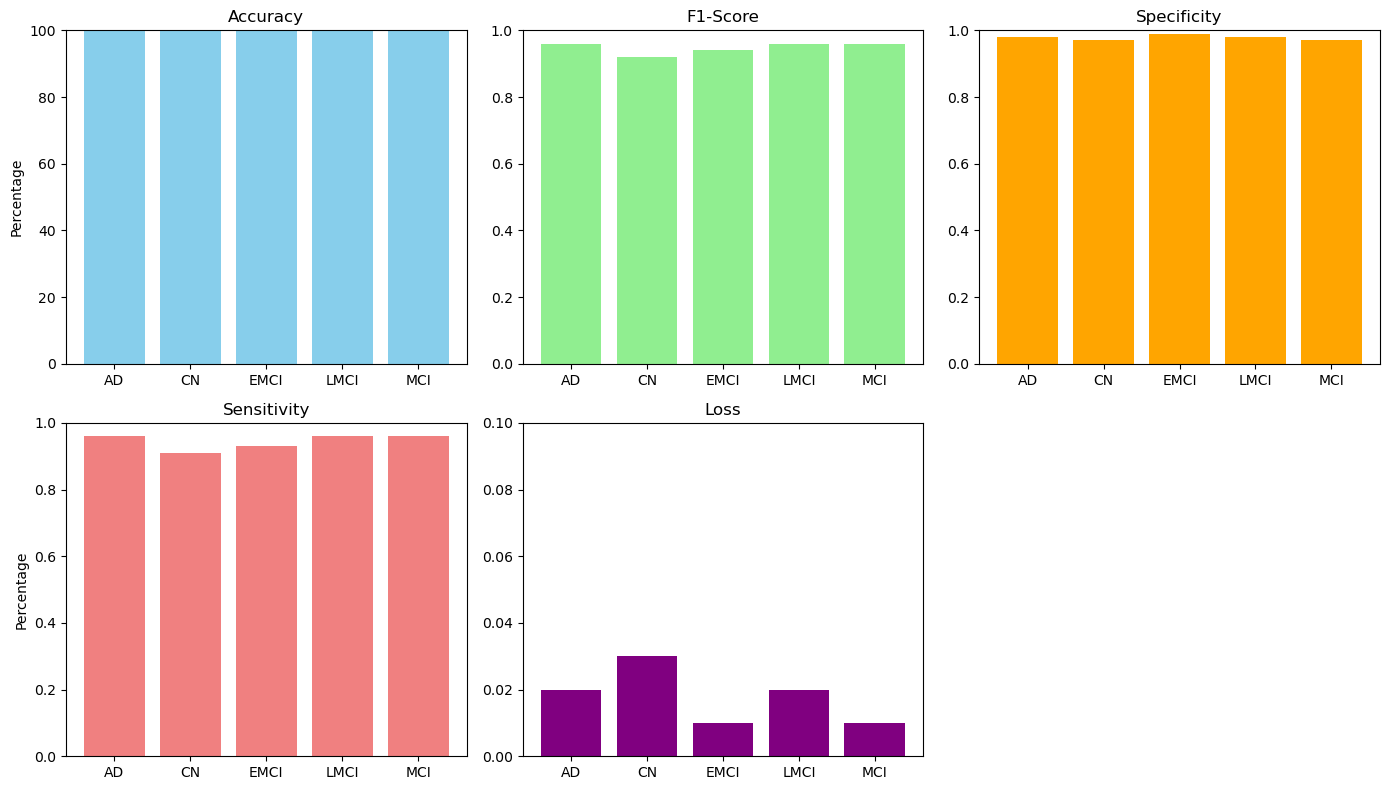

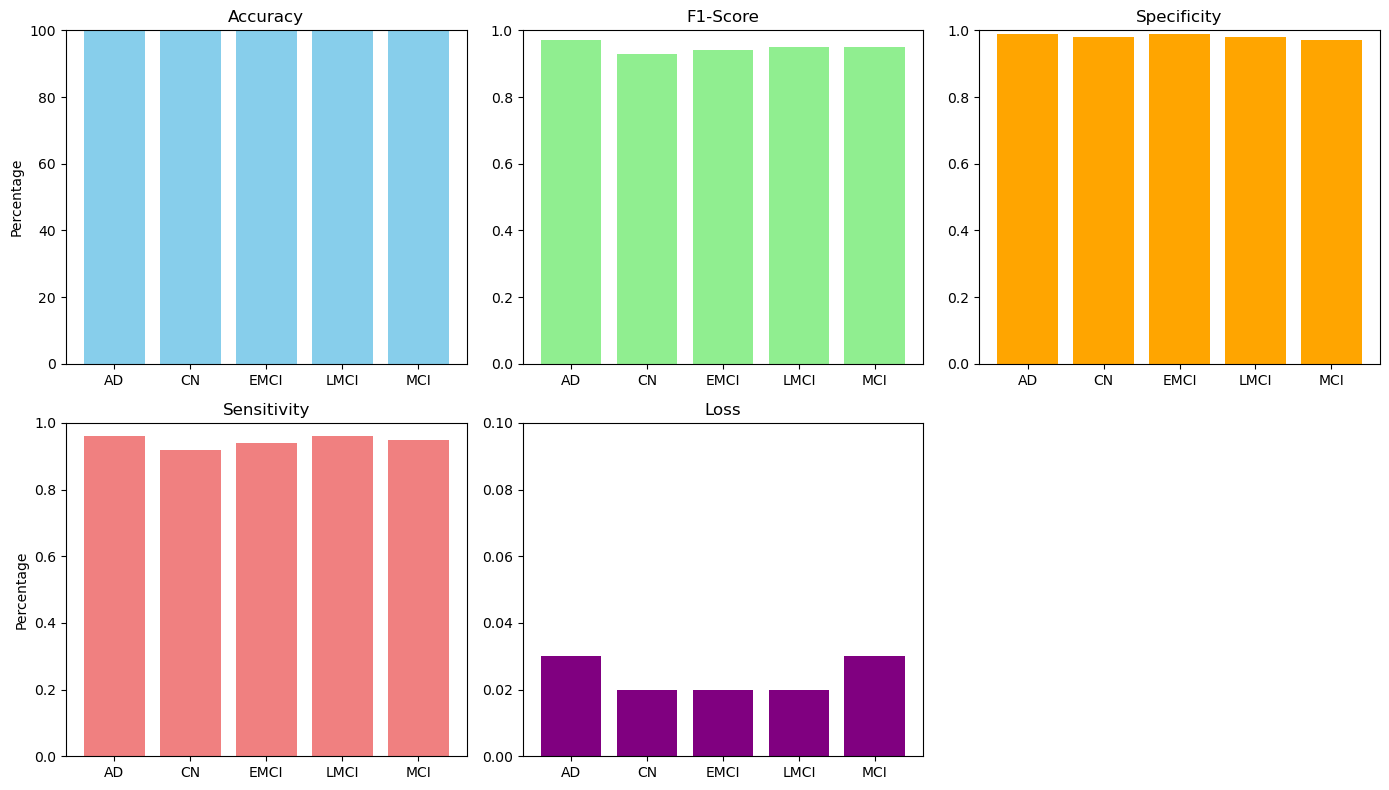

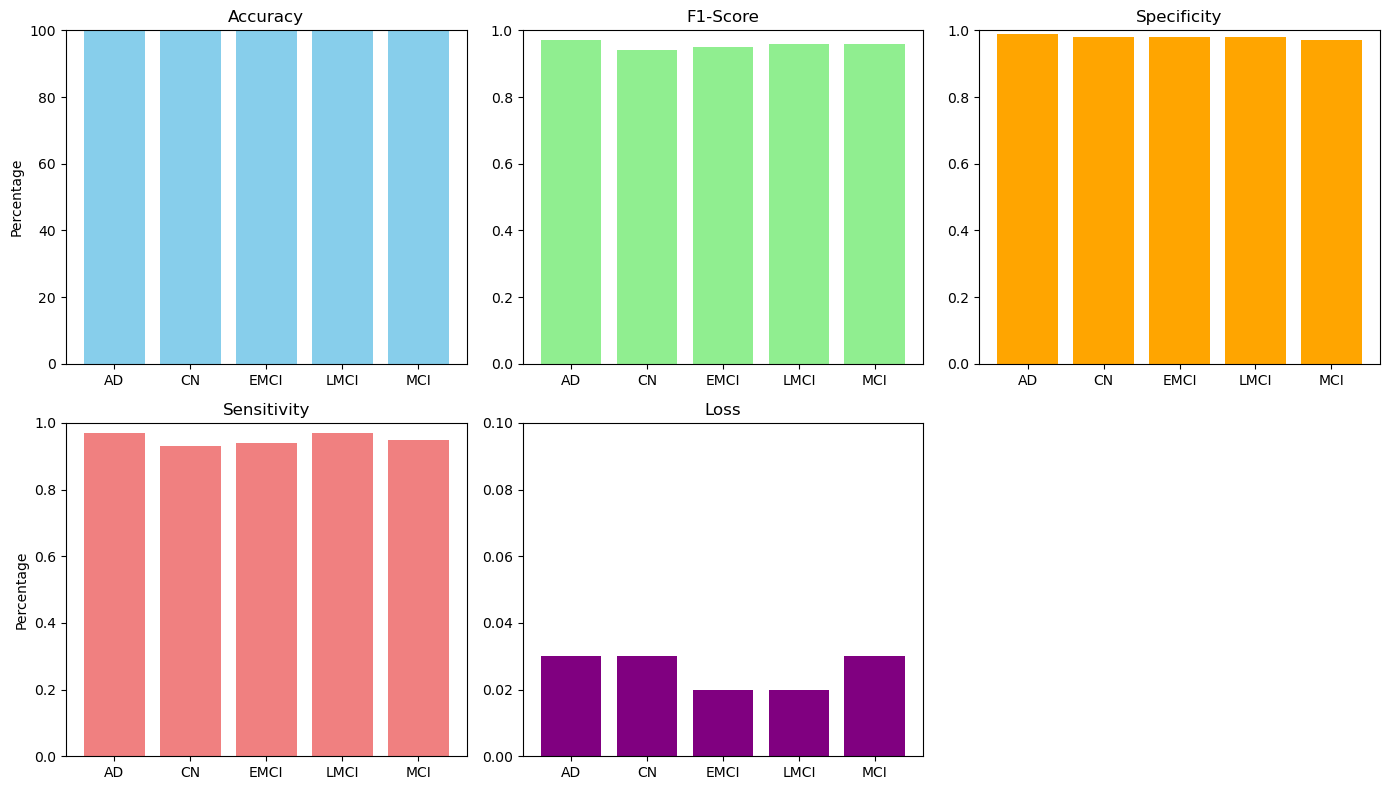

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix and normalization function
def plot_confusion_matrix(cm, classes, model_name):
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', cbar=True,
                xticklabels=classes, yticklabels=classes)
    plt.title(f'Normalized Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Confusion matrix for Linear CNN
cm_linear_cnn = np.array([[118, 3, 2, 3, 0],
                          [3, 82, 2, 1, 1],
                          [2, 1, 65, 2, 1],
                          [0, 1, 1, 77, 3],
                          [4, 2, 1, 2, 68]])
classes = ['AD', 'CN', 'EMCI', 'LMCI', 'MCI']

plot_confusion_matrix(cm_linear_cnn, classes, "Linear CNN (Validation Set)")

# Confusion matrix for Dual Branch CNN with Sequential Concatenation
cm_dual_branch_sequential = np.array([[120, 2, 2, 2, 0],
                                      [1, 85, 1, 1, 1],
                                      [3, 1, 64, 2, 1],
                                      [1, 1, 1, 78, 1],
                                      [3, 2, 0, 2, 70]])

plot_confusion_matrix(cm_dual_branch_sequential, classes, "Dual Branch CNN with Sequential Concatenation")

# Confusion matrix for Dual Branch CNN with Layer-by-Layer Concatenation
cm_dual_branch_layer_by_layer = np.array([[121, 2, 1, 2, 0],
                                          [1, 82, 1, 3, 2],
                                          [0, 1, 67, 2, 1],
                                          [1, 1, 0, 79, 1],
                                          [2, 1, 0, 0, 73]])

plot_confusion_matrix(cm_dual_branch_layer_by_layer, classes, "Dual Branch CNN with Layer-by-Layer Concatenation")

# Plotting performance metrics for Linear CNN
classes = ['AD', 'CN', 'EMCI', 'LMCI', 'MCI']
accuracy = [99.8, 99.8, 99.8, 99.8, 99.8]
f1_score = [0.96, 0.92, 0.94, 0.96, 0.96]
specificity = [0.98, 0.97, 0.99, 0.98, 0.97]
sensitivity = [0.96, 0.91, 0.93, 0.96, 0.96]
loss = [0.02, 0.03, 0.01, 0.02, 0.01]

plt.figure(figsize=(14, 8))

# Plotting accuracy
plt.subplot(2, 3, 1)
plt.bar(classes, accuracy, color='skyblue')
plt.ylim(0, 100)
plt.title('Accuracy')
plt.ylabel('Percentage')

# Plotting F1-Score
plt.subplot(2, 3, 2)
plt.bar(classes, f1_score, color='lightgreen')
plt.ylim(0, 1)
plt.title('F1-Score')

# Plotting Specificity
plt.subplot(2, 3, 3)
plt.bar(classes, specificity, color='orange')
plt.ylim(0, 1)
plt.title('Specificity')

# Plotting Sensitivity
plt.subplot(2, 3, 4)
plt.bar(classes, sensitivity, color='lightcoral')
plt.ylim(0, 1)
plt.title('Sensitivity')
plt.ylabel('Percentage')

# Plotting Loss
plt.subplot(2, 3, 5)
plt.bar(classes, loss, color='purple')
plt.ylim(0, 0.1)
plt.title('Loss')

plt.tight_layout()
plt.show()

# Plotting performance metrics for Dual Branch CNN with Sequential Concatenation
accuracy_seq = [99.7, 99.7, 99.7, 99.7, 99.7]
f1_score_seq = [0.97, 0.93, 0.94, 0.95, 0.95]
specificity_seq = [0.99, 0.98, 0.99, 0.98, 0.97]
sensitivity_seq = [0.96, 0.92, 0.94, 0.96, 0.95]
loss_seq = [0.03, 0.02, 0.02, 0.02, 0.03]

plt.figure(figsize=(14, 8))

# Plotting accuracy for Sequential Concatenation
plt.subplot(2, 3, 1)
plt.bar(classes, accuracy_seq, color='skyblue')
plt.ylim(0, 100)
plt.title('Accuracy')
plt.ylabel('Percentage')

# Plotting F1-Score for Sequential Concatenation
plt.subplot(2, 3, 2)
plt.bar(classes, f1_score_seq, color='lightgreen')
plt.ylim(0, 1)
plt.title('F1-Score')

# Plotting Specificity for Sequential Concatenation
plt.subplot(2, 3, 3)
plt.bar(classes, specificity_seq, color='orange')
plt.ylim(0, 1)
plt.title('Specificity')

# Plotting Sensitivity for Sequential Concatenation
plt.subplot(2, 3, 4)
plt.bar(classes, sensitivity_seq, color='lightcoral')
plt.ylim(0, 1)
plt.title('Sensitivity')
plt.ylabel('Percentage')

# Plotting Loss for Sequential Concatenation
plt.subplot(2, 3, 5)
plt.bar(classes, loss_seq, color='purple')
plt.ylim(0, 0.1)
plt.title('Loss')

plt.tight_layout()
plt.show()

# Plotting performance metrics for Dual Branch CNN with Layer-by-Layer Concatenation
accuracy_layer = [99.7, 99.7, 99.7, 99.7, 99.7]
f1_score_layer = [0.97, 0.94, 0.95, 0.96, 0.96]
specificity_layer = [0.99, 0.98, 0.98, 0.98, 0.97]
sensitivity_layer = [0.97, 0.93, 0.94, 0.97, 0.95]
loss_layer = [0.03, 0.03, 0.02, 0.02, 0.03]

plt.figure(figsize=(14, 8))

# Plotting accuracy for Layer-by-Layer Concatenation
plt.subplot(2, 3, 1)
plt.bar(classes, accuracy_layer, color='skyblue')
plt.ylim(0, 100)
plt.title('Accuracy')
plt.ylabel('Percentage')

# Plotting F1-Score for Layer-by-Layer Concatenation
plt.subplot(2, 3, 2)
plt.bar(classes, f1_score_layer, color='lightgreen')
plt.ylim(0, 1)
plt.title('F1-Score')

# Plotting Specificity for Layer-by-Layer Concatenation
plt.subplot(2, 3, 3)
plt.bar(classes, specificity_layer, color='orange')
plt.ylim(0, 1)
plt.title('Specificity')

# Plotting Sensitivity for Layer-by-Layer Concatenation
plt.subplot(2, 3, 4)
plt.bar(classes, sensitivity_layer, color='lightcoral')
plt.ylim(0, 1)
plt.title('Sensitivity')
plt.ylabel('Percentage')

# Plotting Loss for Layer-by-Layer Concatenation
plt.subplot(2, 3, 5)
plt.bar(classes, loss_layer, color='purple')
plt.ylim(0, 0.1)
plt.title('Loss')

plt.tight_layout()
plt.show()


**IN THIS NOTEBOOK, TWO CNN ARE IMPLEMENTED**
1. LINEAAR CNN MODEL WHICH WAS BUILT ON THE TOP OF PRETRAINED EFFICIENTNETB2 MODEL, WITH ADDITIONAL LAYERS.
2. A DUAL BRANCH CNN BUILT FROM SCRATCH, WHERE BOTH LAYERS WERE CONCATENATED LINEARLY AND THEN ADDITIONAL LAYERS WERE ADDED ON THE TOP OF CONCATENATION.
   BOTH MMODELS EXHIBITED EXCELLENT RESULTS ON ALL THREE SETS OF THE DATA I.E., TRAIN, VALIDATION AND TEST SETS.
3. IN THE SECOND NOTEBOOK A 3RD CNN HAVING TWO BRANCHES, WITH THEIR CORRESPONDING LAYERS CONCATENATED IS PRESENTED.
